## Project report for Transaction Fraud
CEBD 1260 - 2021winter Session
- Team Member: Christian Boullosa
- Context of report: Transaction fraud detection from two input datasets.




###  Introduction:
Transaction fraud is a growing concern for Financial institutions due to damages and losses of revenue, using machine learning (ML) approach the goal of this task is to predict the probability that an online customer’s transaction is fraudulent, as denoted by the binary target isFraud (=1 for fraud and =0 for no fraud).  lightGBM-Classifier was used based on results from previous classes and similar datasets

Assumptions:
- Files used:
    - train_transaction.csv, main data set 
    - train_identity.csv, detailed data set
    - with a many to one relationship linked by Transaction ID feature
- Feature: as the features were masked the following assumptions were made for some of the features:
    - Card1 – Card 5 information was merged to create a unique ID, card4 and card6 features were excluded as contains useful information.
    - Transaction DT was assumed to contain transaction date time and needed to be converted from object to date format with setting the origin time to 2017-11-30:00:00:00 
    - The other object features were converted with create dummy function.
    - Due to the high number of unknown variables, features with a correlation of 0.7 and higher were removed for the dataset before modeling process




### High Level Model Methodology Strategy:
- Data was divided in Train/Test/Valid split for benchmark and merged data-frames during model process.
- Benchmark was executed for main data-frame with RF and LightGBM (default) to obtain ideal model. Bur only for Train/Valid splits
- Simple K-Folds — with K=5 for Benchmark and merged data-frames
- Feature importance ranking to improve the model only on merged data-frames (one Cycle)


In [297]:
#--------------------------
# Python Libraries
# --------------------------
import numpy as np   # import numpy
import pandas as pd  # import pandas
import matplotlib.pyplot as plt # matplotlib 
import seaborn as sns
import datetime
import time
import gc
import os
import operator
import pickle
import warnings # warning level
#
#  sklearn related libraries
# --------------------------
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score,precision_recall_fscore_support
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import glob
import lightgbm as lgb # load lightGBM model
%matplotlib inline


In [298]:
# Set display size
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [299]:
gc.collect()

117

## 1 - Processing Data

### 1.1 - Loading dataframes and initial review 

In [300]:
# loading data from sources
DATA_PATH = 'C:\\Users\\CBTec\\OneDrive\\Documents\\CEBD1260-2204-1-winter-2021\\Data\\transaction_fraud'
df1 = pd.read_csv(DATA_PATH+r'\train_transaction.csv') 
df2 = pd.read_csv(DATA_PATH+r'\train_identity.csv')

In [301]:
df1.shape, df2.shape

((590540, 394), (144233, 41))

In [302]:
df1.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [303]:
df2.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


#### determine if data imbalance

In [304]:
# Checking for the ration of 1 and 0
print ("missing ratio: {:.2f}%".format(100*(df2['TransactionID'].count()/df1['TransactionID'].count())))

missing ratio: 24.42%


In [305]:
df1['isFraud'].describe()

count    590540.000000
mean          0.034990
std           0.183755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

In [306]:
df1.isFraud[(df1['isFraud'] == 1)].count()

20663

In [307]:
tf = df1['isFraud'].count() 
f = df1.isFraud[(df1['isFraud'] == 1)].count()
per = (f/tf)*100
print("Percentage of fraud cases versus non-fraud: {:.2f} / {:.2f} x 100 = {:.2f}%".format(f,tf,per))

Percentage of fraud cases versus non-fraud: 20663.00 / 590540.00 x 100 = 3.50%


#### ... Dataset is imbalance as ration of 1 compare to 0 is 3.5% of all data

## 1.2 Merging data

In [308]:
# Checking the type of relationship betweent the two tables to see if they need to merge now or later:

print("# if IDs :", df1['TransactionID'].nunique(),"shape:", df1.shape)
print("# if IDs :", df2['TransactionID'].nunique(),"shape", df2.shape)

# if IDs : 590540 shape: (590540, 394)
# if IDs : 144233 shape (144233, 41)


#### ... due to the many to one relationship we can merge now

In [309]:
# As relation is many to 1 we can merge by transaciton_ID the two datasets as Train_df
train_df = df1.merge(df2,on='TransactionID',how='left') # merge with main table
train_df.shape


(590540, 434)

In [310]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [311]:
# validatin dtypes and feature name
train_df.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

## 1.3 Handeling Nan values and potential outliers
 
- Validate skweness of the data...if highly skewed we should concider median values insted of mean
- For non numerical features...we can fill nan with 'Unknown'



In [312]:
train_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

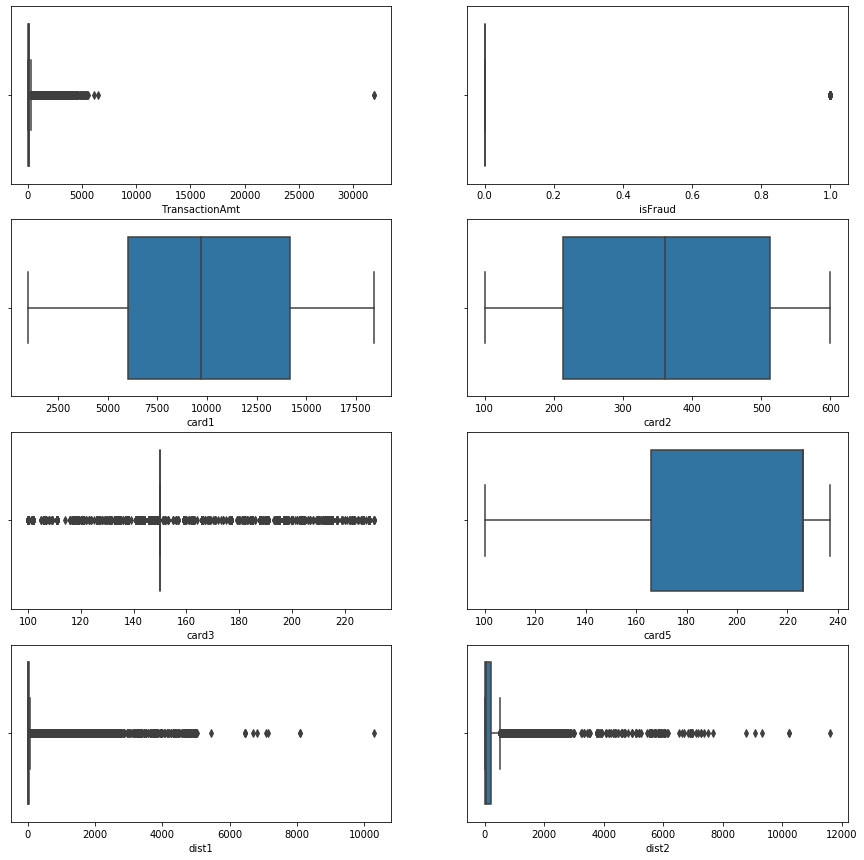

In [313]:
# sample from some ID values
fig, axs = plt.subplots(4,2, figsize = (15,15))
plt1 = sns.boxplot(train_df['TransactionAmt'], ax = axs[0,0])
plt2 = sns.boxplot(train_df['isFraud'], ax = axs[0,1])

plt3 = sns.boxplot(train_df['card1'], ax = axs[1,0])
plt4 = sns.boxplot(train_df['card2'], ax = axs[1,1])

plt5 = sns.boxplot(train_df['card3'], ax = axs[2,0])
plt6 = sns.boxplot(train_df['card5'], ax = axs[2,1])

plt7 = sns.boxplot(train_df['dist1'], ax = axs[3,0])
plt8 = sns.boxplot(train_df['dist2'], ax = axs[3,1])



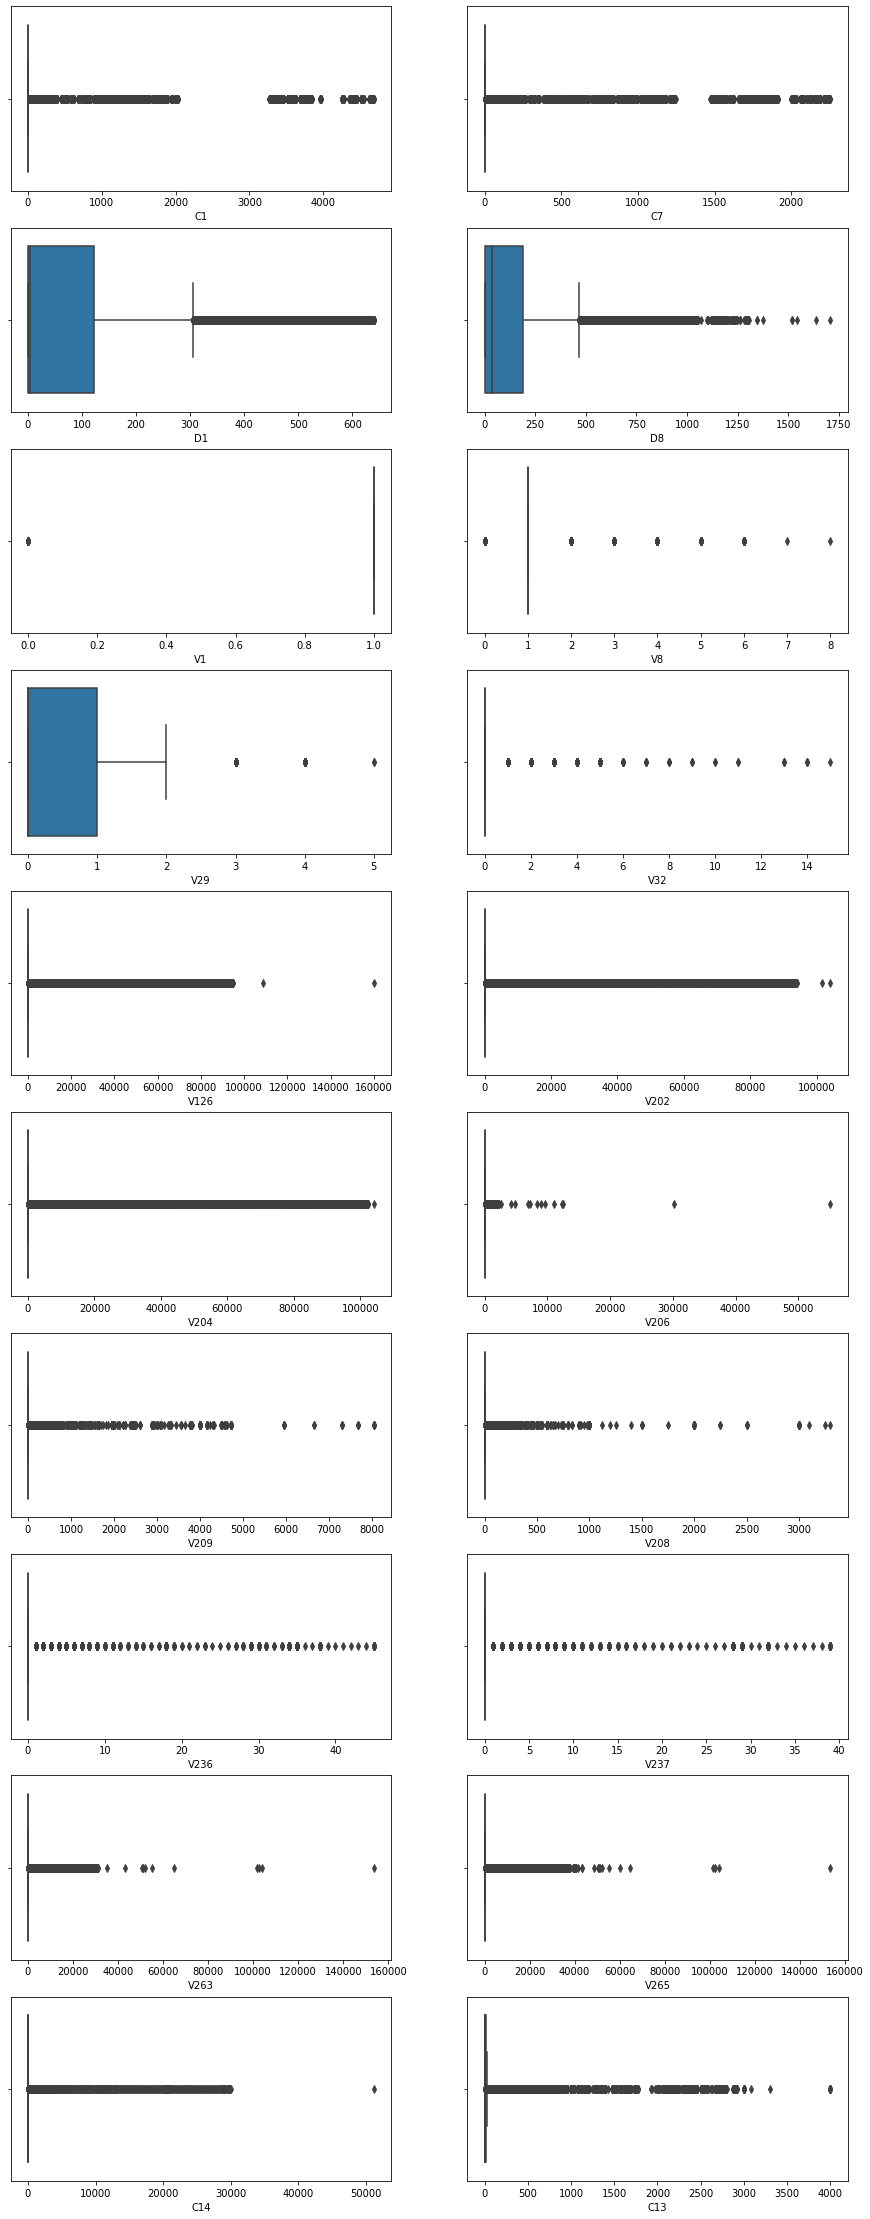

In [314]:
# sample from some ID values
fig, axs = plt.subplots(10,2, figsize = (15,40))
plt1 = sns.boxplot(train_df['C1'], ax = axs[0,0])
plt2 = sns.boxplot(train_df['C7'], ax = axs[0,1])

plt3 = sns.boxplot(train_df['D1'], ax = axs[1,0])
plt4 = sns.boxplot(train_df['D8'], ax = axs[1,1])

plt5 = sns.boxplot(train_df['V1'], ax = axs[2,0])
plt6 = sns.boxplot(train_df['V8'], ax = axs[2,1])

plt7 = sns.boxplot(train_df['V29'], ax = axs[3,0])
plt8 = sns.boxplot(train_df['V32'], ax = axs[3,1])

plt9 = sns.boxplot(train_df['V126'], ax = axs[4,0])
plt10 = sns.boxplot(train_df['V202'], ax = axs[4,1])

plt11 = sns.boxplot(train_df['V204'], ax = axs[5,0])
plt12 = sns.boxplot(train_df['V206'], ax = axs[5,1])

plt13 = sns.boxplot(train_df['V209'], ax = axs[6,0])
plt14 = sns.boxplot(train_df['V208'], ax = axs[6,1])

plt15 = sns.boxplot(train_df['V236'], ax = axs[7,0])
plt16 = sns.boxplot(train_df['V237'], ax = axs[7,1])

plt17 = sns.boxplot(train_df['V263'], ax = axs[8,0])
plt18 = sns.boxplot(train_df['V265'], ax = axs[8,1])


plt19 = sns.boxplot(train_df['V273'], ax = axs[9,0])
plt20 = sns.boxplot(train_df['V272'], ax = axs[9,1])

plt21 = sns.boxplot(train_df['C14'], ax = axs[9,0])
plt22 = sns.boxplot(train_df['C13'], ax = axs[9,1])

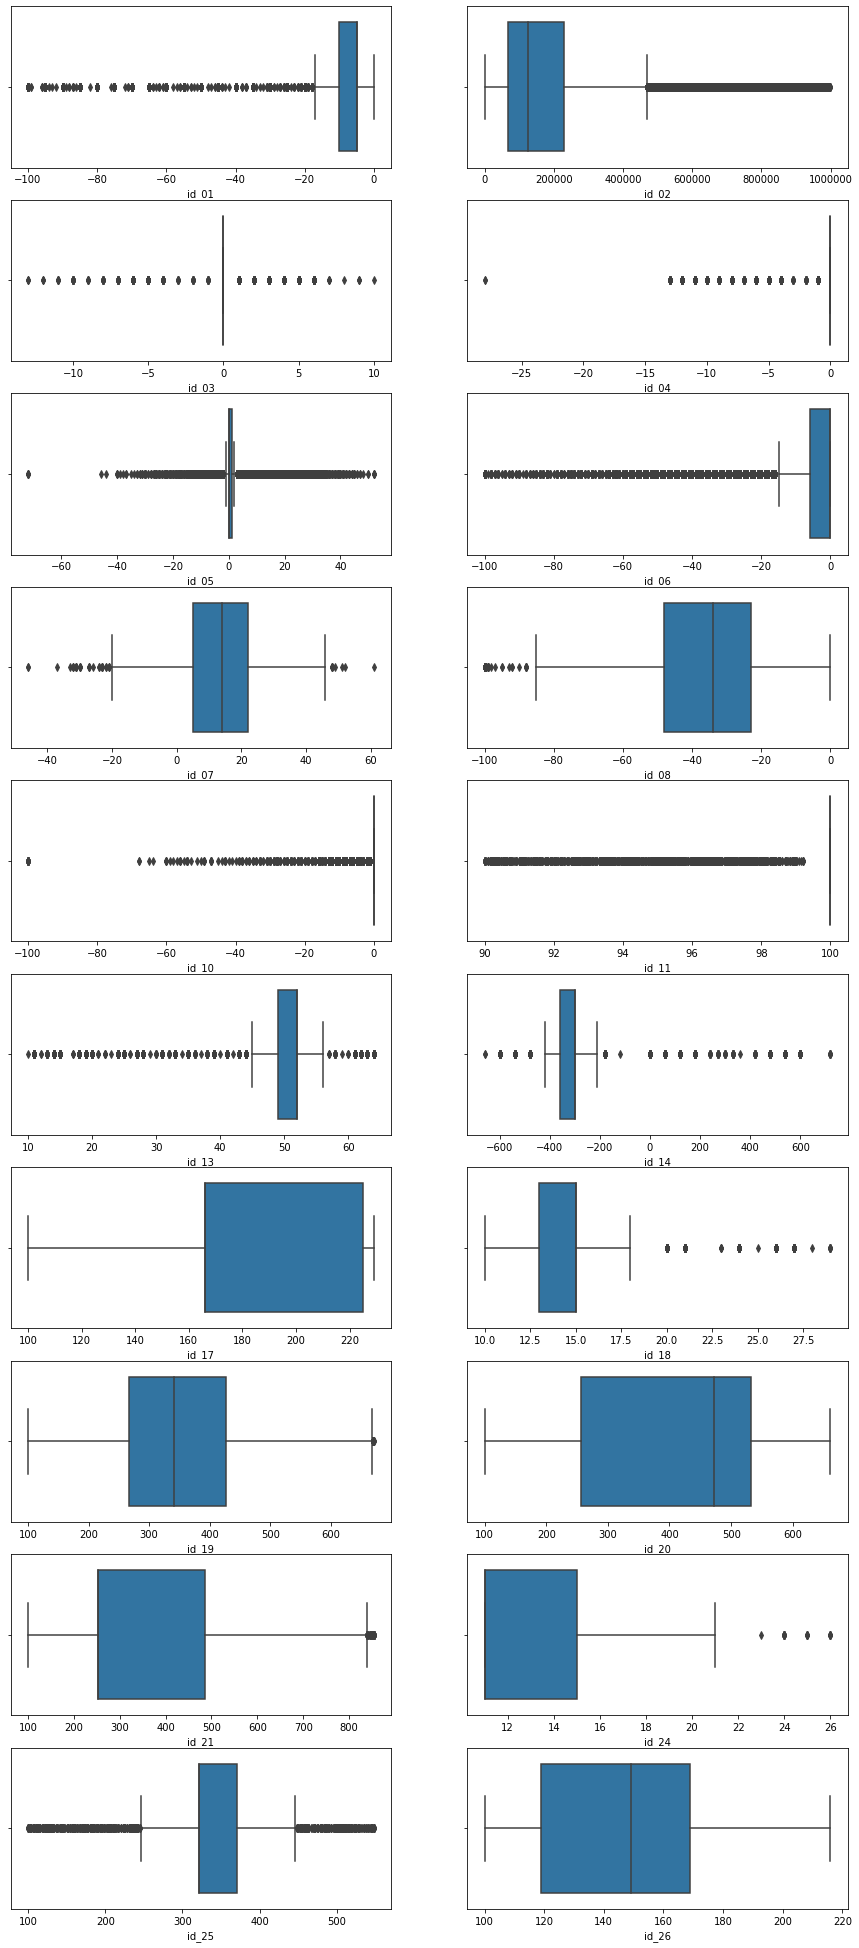

In [315]:
# sample from some ID values
fig, axs = plt.subplots(10,2, figsize = (15,35))
plt1 = sns.boxplot(train_df['id_01'], ax = axs[0,0])
plt2 = sns.boxplot(train_df['id_02'], ax = axs[0,1])

plt3 = sns.boxplot(train_df['id_03'], ax = axs[1,0])
plt4 = sns.boxplot(train_df['id_04'], ax = axs[1,1])

plt5 = sns.boxplot(train_df['id_05'], ax = axs[2,0])
plt6 = sns.boxplot(train_df['id_06'], ax = axs[2,1])

plt7 = sns.boxplot(train_df['id_07'], ax = axs[3,0])
plt8 = sns.boxplot(train_df['id_08'], ax = axs[3,1])

plt9 = sns.boxplot(train_df['id_10'], ax = axs[4,0])
plt10 = sns.boxplot(train_df['id_11'], ax = axs[4,1])

plt11 = sns.boxplot(train_df['id_13'], ax = axs[5,0])
plt12 = sns.boxplot(train_df['id_14'], ax = axs[5,1])

plt13 = sns.boxplot(train_df['id_17'], ax = axs[6,0])
plt14 = sns.boxplot(train_df['id_18'], ax = axs[6,1])

plt15 = sns.boxplot(train_df['id_19'], ax = axs[7,0])
plt16 = sns.boxplot(train_df['id_20'], ax = axs[7,1])

plt17 = sns.boxplot(train_df['id_21'], ax = axs[8,0])
plt18 = sns.boxplot(train_df['id_24'], ax = axs[8,1])


plt19 = sns.boxplot(train_df['id_25'], ax = axs[9,0])
plt20 = sns.boxplot(train_df['id_26'], ax = axs[9,1])


#### ...most of the data is skewed, therefore we will use median for nan vaues, this can be to replace nan based on mean or other chrateria

In [316]:

def get_nan_dic(df):
    """
    get NaN dictionary
    return: a dictionary with #of null values as key and feature names as value
    """
    nulls = df.isna()
    nan_dic ={}
    for f in df.columns:
        if nulls[f].sum() > 0:
            c=nulls[f].sum()
            nan_dic[c]=[]
    for f in df.columns:
        if nulls[f].sum() > 0:
            c = nulls[f].sum()
            nan_dic[c].append(f)
    return nan_dic

In [317]:
nan_list = get_nan_dic(train_df)

In [318]:
for k, v in sorted(nan_list.items()):
    if k != 0:
        print (k,v)
    

12 ['V279', 'V280', 'V284', 'V285', 'V286', 'V287', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']
314 ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']
1269 ['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
1565 ['card3']
1571 ['card6']
1577 ['card4']
4259 ['card5']
8933 ['card2']
65706 ['addr1', 'addr2']
76022 ['D10']
76073 ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
77096 ['V53', 

In [319]:
# Funtion to address Nan
def process_nan(df):
    print("processing Nan values, intial total sum of nan values: ", df.isnull().sum().sum())

    nan_info = pd.DataFrame(df.isnull().sum()).reset_index()
    nan_info.columns = ['col', 'nan_cnt']
    nan_info.sort_values(by='nan_cnt', ascending=False, inplace=True)
    
    # Columns with missing values
    cols_with_missing = nan_info.loc[nan_info.nan_cnt > 0].col.values
    
    # Fill missing values (numbers) with the median
    for f in cols_with_missing:
        if str(df[f].dtype) != 'object':
            df[f].fillna(df[f].median(), inplace=True)
    
    # Fill missing values (objects) with Unknown
    for f in cols_with_missing:
        if str(df[f].dtype) == 'object':
            df[f].fillna('Unknown', inplace=True)
    
    # Check if there are still Nan values
    nan_info = pd.DataFrame(df.isnull().sum()).reset_index()
    nan_info.columns = ['col', 'nan_cnt']
    nan_info.sort_values(by='nan_cnt', ascending=False, inplace=True)
    print(nan_info)
    # print("Final sum of nan values: ", df.isnull().sum().sum())

In [320]:
process_nan(train_df)

processing Nan values, intial total sum of nan values:  115523073
                col  nan_cnt
0     TransactionID        0
285            V231        0
296            V242        0
295            V241        0
294            V240        0
293            V239        0
292            V238        0
291            V237        0
290            V236        0
289            V235        0
288            V234        0
287            V233        0
286            V232        0
284            V230        0
325            V271        0
283            V229        0
282            V228        0
281            V227        0
280            V226        0
279            V225        0
278            V224        0
277            V223        0
276            V222        0
275            V221        0
274            V220        0
273            V219        0
297            V243        0
298            V244        0
299            V245        0
300            V246        0
323            V269        0
322   

In [321]:
 train_df.isnull().sum().sum()

0

### - dist1 and dist2 can be potentially be used as user ID, so we can be used to create card ID

In [322]:
train_df[train_df['dist1'] > 10000][['dist1', 'isFraud']].count()

dist1      1
isFraud    1
dtype: int64

In [323]:
train_df[train_df['dist1'] > 10000][['dist1', 'isFraud']]

,dist1,isFraud
273014,10286.0,0


In [324]:
train_df[train_df['dist2'] > 10000]['dist2'].count()

3

In [325]:
train_df[train_df['dist2'] > 10000][['dist2', 'isFraud']]

,dist2,isFraud
392833,11623.0,0
493028,10237.0,0
493038,10237.0,0


In [326]:
train_df[train_df['TransactionAmt'] > 10000]['TransactionAmt'].count()

2

In [327]:
train_df[train_df['TransactionAmt'] > 10000][['TransactionAmt','isFraud']]

,TransactionAmt,isFraud
274336,31937.391,0
274339,31937.391,0


In [328]:
# Updating train DF
print(train_df.shape)
train_df = train_df[(train_df['dist1'] < 10000) & (train_df['dist2'] < 10000) & (train_df['TransactionAmt'] < 10000)]
print(train_df.shape)

(590540, 434)
(590534, 434)


## 1.4 Handeling features with hight correlation

### - Creation functions to display and manage correlation

In [329]:
#let us check this group, I wrote this function to plot correlation matrix as heatmap
def plot_corr(df,cols):
    if len(cols) > 20:  
        fig = plt.figure(figsize=(24,16))
        sns.heatmap(df[cols].corr(),cmap='RdBu_r', annot=True, center=0.0)
        plt.show()
    else:    
        fig = plt.figure(figsize=(12,8))
        sns.heatmap(df[cols].corr(),cmap='RdBu_r', annot=True, center=0.0)
        plt.show() 
        

In [330]:
# Funtion to order correlation items
#------------------------------------
def corr_entries(df):
    mat = df.corr().abs()

    # Remove duplicate and identity entries
    mat.loc[:,:] = np.tril(mat.values, k=-1)
    mat = mat[mat>0]

    # Unstack, sort ascending, and reset the index, so features are in columns
    # instead of indexes and rename these it for good measure.
    mat = mat.unstack().sort_values(ascending=False).reset_index().rename(columns=\
                                                                          {"level_0": "feature_a"\
                                                                           , "level_1": "feature_b"\
                                                                           , 0: "correlation"})
    mat.dropna(inplace = True)
    return (mat)

# Funtion to select corr pair to remove
#-------------------------------------------------
# Note: Assumption/Dependency: Funtion asssumes you run corr_entries 

def corr_list(df, n):
    # r = []
    # r = np.array(r, dtype = 'object')
    # df.dropna(inplace = True)
    return df[((df['correlation'] >= n) | (df['correlation'] <= -n)) & (df['correlation'] != 1.00)]['feature_b'].unique()

# Note: For Future: Combine the two functions for main code 

In [331]:
train_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905340e+05,590534.000000,5.905340e+05,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.00000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,590534.000000,59

In [332]:
# 
features_C = [f for f in train_df.columns.values if ('C' in f)  and (f not in 'ProductCD')]
print ("C features:\n",features_C)

features_D = [f for f in train_df.columns.values if 'D' in f and \
              (f not in ['TransactionID', 'TransactionDT', 'ProductCD', 'DeviceType', 'DeviceInfo'])]
print ("D features:\n",features_D)

features_id = [f for f in train_df.columns.values if 'id_' in f]
print ("id_ features:\n",features_id)

features_V = [f for f in train_df.columns.values if 'V' in f]
print ("V features:\n",features_V)




C features:
 ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
D features:
 ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
id_ features:
 ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
V features:
 ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61

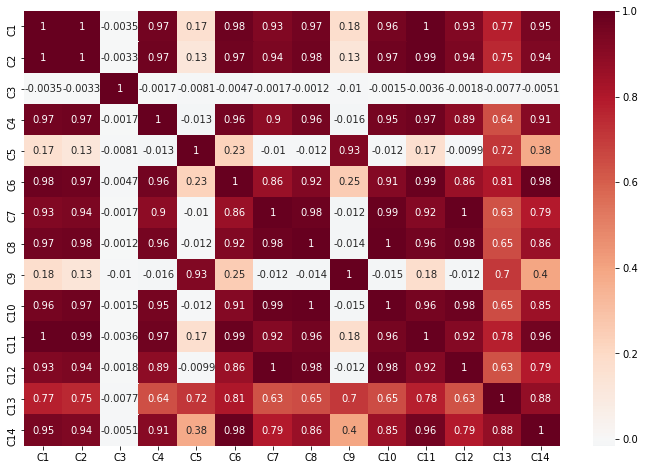

In [333]:
# Displaying correlations:
plot_corr(train_df,features_C)

In [334]:
corrV = corr_entries(train_df[features_C])

In [335]:
# Scenario 1: n = 0.95 
n = 0.95
drop_list = corr_list(corrV,n)
print(drop_list, "\n")
print(len(drop_list),"features out of", train_df[features_C].shape[1], " will be droped")

['C12' 'C10' 'C11' 'C2' 'C14' 'C8' 'C6' 'C4'] 

8 features out of 14  will be droped


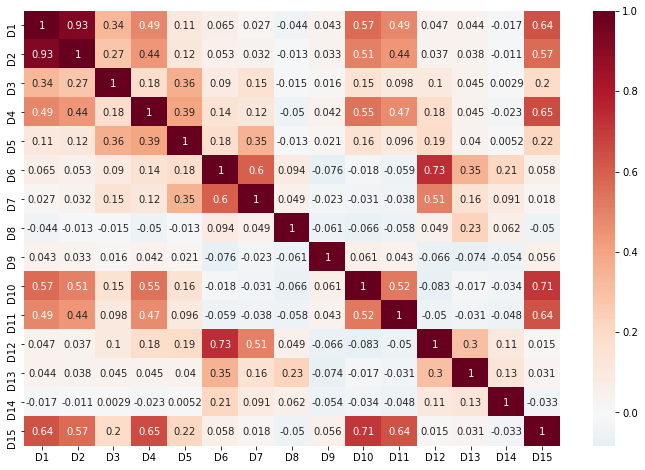

In [336]:
plot_corr(train_df,features_D)

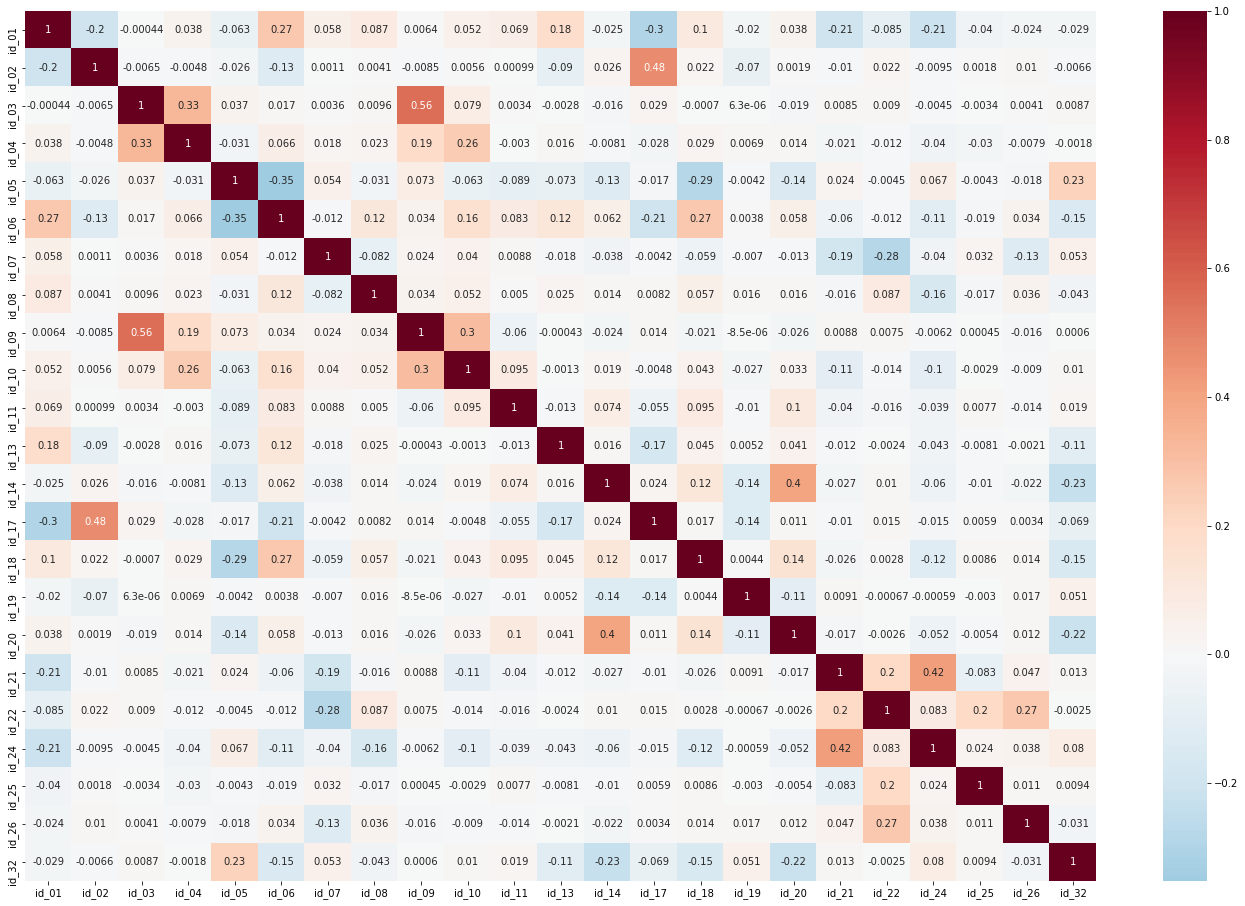

In [337]:
plot_corr(train_df,features_id)

##### ... the id values can remain in the model as they don't have high correlation

#### - due to the hight number of V features we will use the function to determine correlation treashould 

In [338]:
%%time
# calling corr funtion
corrV = corr_entries(train_df[features_V])

Wall time: 2min 32s


In [339]:
corrV.head(20)

,feature_a,feature_b,correlation
0,V95,V101,0.999594
1,V279,V293,0.999568
2,V95,V322,0.999426
3,V101,V322,0.999383
4,V167,V177,0.999346
5,V101,V293,0.998918
6,V97,V103,0.998789
7,V95,V279,0.998709
8,V280,V295,0.998623
9,V95,V293,0.998474


In [340]:
# Scenario 1: n = 0.8 
n = 0.8
drop_list = corr_list(corrV,n)
print(drop_list, "\n")
print(len(drop_list),"features out of", train_df[features_V].shape[1], " will be droped")

['V101' 'V293' 'V322' 'V177' 'V103' 'V279' 'V295' 'V324' 'V211' 'V316'
 'V102' 'V164' 'V323' 'V213' 'V269' 'V134' 'V132' 'V231' 'V133' 'V332'
 'V179' 'V233' 'V333' 'V318' 'V306' 'V317' 'V18' 'V97' 'V182' 'V232'
 'V298' 'V331' 'V167' 'V178' 'V280' 'V202' 'V128' 'V143' 'V308' 'V154'
 'V127' 'V212' 'V16' 'V32' 'V251' 'V256' 'V150' 'V219' 'V126' 'V204'
 'V155' 'V156' 'V254' 'V168' 'V299' 'V11' 'V329' 'V151' 'V244' 'V28'
 'V330' 'V49' 'V159' 'V272' 'V196' 'V307' 'V222' 'V292' 'V22' 'V160' 'V70'
 'V72' 'V93' 'V237' 'V58' 'V249' 'V91' 'V304' 'V106' 'V30' 'V192' 'V34'
 'V296' 'V33' 'V94' 'V153' 'V193' 'V145' 'V158' 'V74' 'V199' 'V253' 'V149'
 'V52' 'V43' 'V81' 'V60' 'V163' 'V225' 'V273' 'V21' 'V278' 'V275' 'V239'
 'V183' 'V294' 'V40' 'V140' 'V64' 'V152' 'V71' 'V105' 'V259' 'V201' 'V73'
 'V36' 'V96' 'V339' 'V327' 'V85' 'V321' 'V266' 'V63' 'V147' 'V137' 'V13'
 'V190' 'V57' 'V301' 'V79' 'V218' 'V157' 'V90' 'V54' 'V76' 'V113' 'V271'
 'V203' 'V69' 'V309' 'V51' 'V92' 'V334' 'V315' 'V297' 'V5' 'V31' 

In [341]:
# Scenario 2: n = 0.9 
n = 0.9
drop_list = corr_list(corrV,n)
print(drop_list, "\n")
print(len(drop_list),"features out of", train_df[features_V].shape[1], " will be deroped")

['V101' 'V293' 'V322' 'V177' 'V103' 'V279' 'V295' 'V324' 'V211' 'V316'
 'V102' 'V164' 'V323' 'V213' 'V269' 'V134' 'V132' 'V231' 'V133' 'V332'
 'V179' 'V233' 'V333' 'V318' 'V306' 'V317' 'V18' 'V97' 'V182' 'V232'
 'V298' 'V331' 'V167' 'V178' 'V280' 'V202' 'V128' 'V143' 'V308' 'V154'
 'V127' 'V212' 'V16' 'V32' 'V251' 'V256' 'V150' 'V219' 'V126' 'V204'
 'V155' 'V156' 'V254' 'V168' 'V299' 'V11' 'V329' 'V151' 'V244' 'V28'
 'V330' 'V49' 'V159' 'V272' 'V196' 'V307' 'V222' 'V292' 'V22' 'V160' 'V70'
 'V72' 'V93' 'V237' 'V58' 'V249' 'V91' 'V304' 'V106' 'V30' 'V192' 'V34'
 'V296' 'V33' 'V94' 'V153' 'V193' 'V145' 'V158' 'V74' 'V199' 'V253' 'V149'
 'V52' 'V43' 'V81' 'V60' 'V163' 'V225' 'V273' 'V21' 'V278' 'V275' 'V239'
 'V183' 'V294' 'V40' 'V140' 'V64' 'V152' 'V71' 'V105' 'V259' 'V201' 'V73'
 'V36' 'V96' 'V339' 'V327' 'V85' 'V321' 'V266' 'V63' 'V147' 'V137' 'V13'
 'V190' 'V57' 'V301' 'V79' 'V218' 'V157' 'V90' 'V54' 'V76' 'V113' 'V271'
 'V203' 'V69' 'V309' 'V51' 'V92' 'V334' 'V315' 'V297' 'V5' 'V31' 

In [342]:
# Scenario 3: n = 0.95 
n = 0.95
drop_list = corr_list(corrV,n)
print(drop_list, "\n")
print(len(drop_list),"features out of", train_df[features_V].shape[1], " will be deroped")

['V101' 'V293' 'V322' 'V177' 'V103' 'V279' 'V295' 'V324' 'V211' 'V316'
 'V102' 'V164' 'V323' 'V213' 'V269' 'V134' 'V132' 'V231' 'V133' 'V332'
 'V179' 'V233' 'V333' 'V318' 'V306' 'V317' 'V18' 'V97' 'V182' 'V232'
 'V298' 'V331' 'V167' 'V178' 'V280' 'V202' 'V128' 'V143' 'V308' 'V154'
 'V127' 'V212' 'V16' 'V32' 'V251' 'V256' 'V150' 'V219' 'V126' 'V204'
 'V155' 'V156' 'V254' 'V168' 'V299' 'V11' 'V329' 'V151' 'V244' 'V28'
 'V330' 'V49' 'V159' 'V272' 'V196' 'V307' 'V222' 'V292' 'V22' 'V160' 'V70'
 'V72' 'V93' 'V237' 'V58' 'V249' 'V91' 'V304' 'V106' 'V30' 'V192' 'V34'
 'V296' 'V33' 'V94' 'V153' 'V193' 'V145' 'V158' 'V74' 'V199' 'V253' 'V149'
 'V52' 'V43' 'V81' 'V60' 'V163' 'V225' 'V273' 'V21'] 

101 features out of 339  will be deroped


#### ... scenario 2 seems to be the best option for V values

#### - Creating the correlation function:

In [343]:
%%time
def drop_corr_features(df, n, features):
    print("Handeling correlation ...")
    print("orginal # of features: ", df.shape[1])
    
    # Create correlation matrix
    corr_matrix = df[features].corr().abs()
      
    # Select upper correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
   
    # Find index of feature columns with correlation greater than n 
    drop_list = [column for column in upper.columns if any(upper[column] > n)]
    print("# of drop list:", len(drop_list))
    print(drop_list)
    
    # Drop features
    df.drop(drop_list, axis=1, inplace=True)
    print("# of features after corr removal: ", df.shape[1]) 
    

Wall time: 0 ns


#### ... features treasholds:

- features_C with 0.95 
- features_V with 0.9 
- features_D with 0.7 


In [344]:
%%time
n = 0.95
drop_corr_features(train_df, n, features_C)


Handeling correlation ...
orginal # of features:  434
# of drop list: 8
['C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C12', 'C14']
# of features after corr removal:  426
Wall time: 920 ms


In [345]:
%%time
# testing scenario 1 for v values
n = 0.9
drop_corr_features(train_df, n, features_V)


Handeling correlation ...
orginal # of features:  426
# of drop list: 162
['V5', 'V11', 'V13', 'V16', 'V18', 'V20', 'V21', 'V22', 'V28', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V40', 'V43', 'V45', 'V49', 'V50', 'V51', 'V52', 'V54', 'V57', 'V58', 'V60', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V79', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V94', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V106', 'V113', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V137', 'V140', 'V143', 'V145', 'V147', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V163', 'V164', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V183', 'V190', 'V192', 'V193', 'V196', 'V197', 'V198', 'V199', 'V201', 'V202', 'V203', 'V204', 'V207', 'V211', 'V212', 'V213', 'V216', 'V218', 'V219', 'V222', 'V225', 'V231', 'V232', 'V233', 'V236', 'V237', 'V239', 'V243', 'V244', 'V249', 'V251', 'V253', 'V254', 'V256', 'V257', 'V259', 'V265', 'V266', 'V26

In [346]:
%%time
n = 0.7
drop_corr_features(train_df, n, features_D)

Handeling correlation ...
orginal # of features:  264
# of drop list: 3
['D2', 'D12', 'D15']
# of features after corr removal:  261
Wall time: 785 ms


In [347]:
# final Shape
train_df.shape

(590534, 261)

## 1.5 Optimizing Memory by mananging dtype values

### - Creating generic funtion to conver dtype to the next lower denominator

In [348]:
# Funtion to reduce memory usage by downgrading the dtype values

def optimize_mem(df):
    # Run the dataframe for memory usage 
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe before optomization is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Improved by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    # return df ... to be added in the main code

In [349]:
# validating the dtype before execution: 
# for i in train_df.dtypes:
train_df.dtypes  



TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C3                float64
C5                float64
C7                float64
C9                float64
C13               float64
D1                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8                float64
D9                float64
D10               float64
D11               float64
D13               float64
D14               float64
M1                 object
M2                 object
M3                 object
M4          

#### ... testing the function's results

In [350]:
%%time
optimize_mem(train_df)

Memory usage of dataframe before optomization is 1180.42 MB
Memory usage after optimization is: 301.42 MB
Improved by 74.5%
Wall time: 34.5 s


In [351]:
train_df.dtypes

TransactionID        int32
isFraud               int8
TransactionDT        int32
TransactionAmt     float16
ProductCD         category
card1                int16
card2              float16
card3              float16
card4             category
card5              float16
card6             category
addr1              float16
addr2              float16
dist1              float16
dist2              float16
P_emaildomain     category
R_emaildomain     category
C1                 float16
C3                 float16
C5                 float16
C7                 float16
C9                 float16
C13                float16
D1                 float16
D3                 float16
D4                 float16
D5                 float16
D6                 float16
D7                 float16
D8                 float16
D9                 float16
D10                float16
D11                float16
D13                float16
D14                float16
M1                category
M2                category
M

## 1.6 Converting object values to digital

Converting methodology Notes:

- One-hot (dummy) encoding for features with element that we can figure out the values and use for the model, i.e., id_31:  browser information.
- Label encoder for other categories where we can’t figure out the values and usage, i.e. features M1 to M9 features where values are T or F, but we can’t figure out their usage.
- Features excluded are: addr1, addr2, card1 to card6, TransactionDT, P_emaildomain, R_emaildomain, id_31 to id_34, DeviceType


In [352]:
train_df['card3'].dtypes

dtype('float16')

In [353]:
# printing the nuber of unique values of category features:

category_columns = (train_df.select_dtypes(include=['category', object]).columns).tolist()
for i in category_columns:
    print("{} : number of unique {:2d}".format(i, train_df[i].nunique()))
    

ProductCD : number of unique  5
card4 : number of unique  5
card6 : number of unique  5
P_emaildomain : number of unique 60
R_emaildomain : number of unique 61
M1 : number of unique  3
M2 : number of unique  3
M3 : number of unique  3
M4 : number of unique  4
M5 : number of unique  3
M6 : number of unique  3
M7 : number of unique  3
M8 : number of unique  3
M9 : number of unique  3
id_12 : number of unique  3
id_15 : number of unique  3
id_16 : number of unique  3
id_23 : number of unique  4
id_27 : number of unique  3
id_28 : number of unique  3
id_29 : number of unique  3
id_30 : number of unique 76
id_31 : number of unique 131
id_33 : number of unique 261
id_34 : number of unique  5
id_35 : number of unique  3
id_36 : number of unique  3
id_37 : number of unique  3
id_38 : number of unique  3
DeviceType : number of unique  3
DeviceInfo : number of unique 1787


In [354]:
# reviewing the information of features with less than 10 unique elements  

for i in category_columns:
    if train_df[i].nunique() < 10:   
        print("{} : number of unique {:2d}".format(i, train_df[i].nunique()))
        print (train_df[i].unique())
        print ("\n")


ProductCD : number of unique  5
[W, H, C, S, R]
Categories (5, object): [W, H, C, S, R]


card4 : number of unique  5
[discover, mastercard, visa, american express, Unknown]
Categories (5, object): [discover, mastercard, visa, american express, Unknown]


card6 : number of unique  5
[credit, debit, Unknown, debit or credit, charge card]
Categories (5, object): [credit, debit, Unknown, debit or credit, charge card]


M1 : number of unique  3
[T, Unknown, F]
Categories (3, object): [T, Unknown, F]


M2 : number of unique  3
[T, Unknown, F]
Categories (3, object): [T, Unknown, F]


M3 : number of unique  3
[T, Unknown, F]
Categories (3, object): [T, Unknown, F]


M4 : number of unique  4
[M2, M0, Unknown, M1]
Categories (4, object): [M2, M0, Unknown, M1]


M5 : number of unique  3
[F, T, Unknown]
Categories (3, object): [F, T, Unknown]


M6 : number of unique  3
[T, F, Unknown]
Categories (3, object): [T, F, Unknown]


M7 : number of unique  3
[Unknown, F, T]
Categories (3, object): [Unkn

In [355]:
for i in category_columns:
    if train_df[i].nunique() >= 10:   
        print("{} : number of unique {:2d}".format(i, train_df[i].nunique()))
        print (train_df[i].unique())
        print ("\n")


P_emaildomain : number of unique 60
[Unknown, gmail.com, outlook.com, yahoo.com, mail.com, ..., hotmail.fr, hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]
Length: 60
Categories (60, object): [Unknown, gmail.com, outlook.com, yahoo.com, ..., hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]


R_emaildomain : number of unique 61
[Unknown, gmail.com, hotmail.com, outlook.com, anonymous.com, ..., rocketmail.com, centurylink.net, protonmail.com, cableone.net, sc.rr.com]
Length: 61
Categories (61, object): [Unknown, gmail.com, hotmail.com, outlook.com, ..., centurylink.net, protonmail.com, cableone.net, sc.rr.com]


id_30 : number of unique 76
[Unknown, Android 7.0, iOS 11.1.2, Mac OS X 10_11_6, Windows 10, ..., Mac OS X 10_13_4, Mac OS X 10_13_5, iOS 11.4.0, iOS 11.3.1, iOS 11.4.1]
Length: 76
Categories (76, object): [Unknown, Android 7.0, iOS 11.1.2, Mac OS X 10_11_6, ..., Mac OS X 10_13_5, iOS 11.4.0, iOS 11.3.1, iOS 11.4.1]


id_31 : number of unique 131
[Unknown, samsung 

In [356]:
# Creating category encoding function
def category_encoding(df, ex_lst):
    print("...converting category features to numerical")
    print("\t...excluding: ",ex_lst )
    
    # inventory of cat_features 
    cat_features = (df.select_dtypes(include=['category', object]).columns).tolist()        
    print("...cat features :\n",cat_features)
    
    # exclude features
    for i in ex_lst:
        cat_features.remove(i)
    
    for f in cat_features:
        df[f] = LabelEncoder().fit_transform(df[f])

    print("\n....result")
    print(df[cat_features].dtypes)

In [357]:
%%time
exclusion_list= ['card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']
category_encoding(train_df, exclusion_list)


...converting category features to numerical
	...excluding:  ['card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']
...cat features :
 ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

....result
ProductCD    int32
M1           int32
M2           int32
M3           int32
M4           int32
M5           int32
M6           int32
M7           int32
M8           int32
M9           int32
id_12        int32
id_15        int32
id_16        int32
id_23        int32
id_27        int32
id_28        int32
id_29        int32
id_34        int32
id_35        int32
id_36        int32
id_37        int32
id_38        int32
dtype: object
Wall time: 1.78 s


In [358]:
# updating the list of categorical featutres
for i in exclusion_list:
    category_columns.remove(i)

In [359]:
# validating
for i in category_columns:
    print("{} : number of unique {:2d}".format(i, train_df[i].nunique()))
    print (train_df[i].unique())  
    

ProductCD : number of unique  5
[4 1 0 3 2]
M1 : number of unique  3
[1 2 0]
M2 : number of unique  3
[1 2 0]
M3 : number of unique  3
[1 2 0]
M4 : number of unique  4
[2 0 3 1]
M5 : number of unique  3
[0 1 2]
M6 : number of unique  3
[1 0 2]
M7 : number of unique  3
[2 0 1]
M8 : number of unique  3
[2 0 1]
M9 : number of unique  3
[2 0 1]
id_12 : number of unique  3
[2 1 0]
id_15 : number of unique  3
[2 1 0]
id_16 : number of unique  3
[2 1 0]
id_23 : number of unique  4
[3 2 0 1]
id_27 : number of unique  3
[2 0 1]
id_28 : number of unique  3
[2 1 0]
id_29 : number of unique  3
[2 1 0]
id_34 : number of unique  5
[0 4 3 2 1]
id_35 : number of unique  3
[2 1 0]
id_36 : number of unique  3
[2 0 1]
id_37 : number of unique  3
[2 1 0]
id_38 : number of unique  3
[2 1 0]


## 2.0 Feature Engineering

### 2.1 Creating a unique card ID from card1 - card3, card5, addr1, and, addr2. 

In [360]:
flist = ['card1','card2','card3','card4','card5','card6','addr1','addr2','dist1','dist2']
for i in flist:
    print (i, " unique nunique: ", train_df[i].nunique())


card1  unique nunique:  13553
card2  unique nunique:  500
card3  unique nunique:  114
card4  unique nunique:  5
card5  unique nunique:  119
card6  unique nunique:  5
addr1  unique nunique:  332
addr2  unique nunique:  74
dist1  unique nunique:  2411
dist2  unique nunique:  1697


In [361]:
# creating a card unique id excluding dist1 and dist2 
train_df['card_uid'] = train_df['card1'].astype(int).astype(str) + "-" + train_df['card2'].astype(int).astype(str) + "-" \
+ train_df['card3'].astype(int).astype(str) + "-" + train_df['card5'].astype(int).astype(str) + "-"\
+ train_df['addr1'].astype(int).astype(str) + "-" + train_df['addr2'].astype(int).astype(str)

In [362]:
train_df.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_uid
0,2987000,0,86400,68.5,4,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,37.0,Unknown,Unknown,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,13926-361-150-142-315-87
1,2987001,0,86401,29.0,4,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,37.0,gmail.com,Unknown,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,2755-404-150-102-325-87


In [363]:
# creating a card unique id including dist1 and dist2 
train_df['card_uid2'] = train_df['card1'].astype(int).astype(str) + "-" + train_df['card2'].astype(int).astype(str) + "-" \
+ train_df['card3'].astype(int).astype(str) + "-" + train_df['card5'].astype(int).astype(str) + "-"\
+ train_df['addr1'].astype(int).astype(str) + "-" + train_df['addr2'].astype(int).astype(str)  + "-"\
+ train_df['dist1'].astype(int).astype(str) + "-" + train_df['dist2'].astype(int).astype(str)


In [364]:
train_df.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_uid,card_uid2
0,2987000,0,86400,68.5,4,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,37.0,Unknown,Unknown,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,13926-361-150-142-315-87,13926-361-150-142-315-87-19-37
1,2987001,0,86401,29.0,4,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,37.0,gmail.com,Unknown,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,2755-404-150-102-325-87,2755-404-150-102-325-87-8-37


In [365]:
# creating a card unique id only with card info 
train_df['card_uid3'] = train_df['card1'].astype(int).astype(str) + "-" + train_df['card2'].astype(int).astype(str) + "-" \
+ train_df['card3'].astype(int).astype(str) + "-" + train_df['card5'].astype(int).astype(str)

In [366]:
# verifying wich new card unique id features give the lower number of unique elements

print(train_df['card_uid'].nunique())
print(train_df['card_uid2'].nunique())
print(train_df['card_uid3'].nunique())

42613
122774
14815


In [367]:
# # since we can determine dist1 and dist2 we will keep it out of the card id creation: we can drop card_uid2 and card_uid3

# train_df.drop(['card_uid2','card_uid3'], axis =1, inplace = True)


### - handeling card4 and card 6

In [368]:
print("card4:", train_df['card4'].unique())
print("card6:", train_df['card6'].unique())

card4: [discover, mastercard, visa, american express, Unknown]
Categories (5, object): [discover, mastercard, visa, american express, Unknown]
card6: [credit, debit, Unknown, debit or credit, charge card]
Categories (5, object): [credit, debit, Unknown, debit or credit, charge card]


In [369]:
# creating a function for future use
def create_cardid(df):
    # creating the unique card identifier with flist'card1','card2','card3','card5','addr1','addr2'
    # converting card4 and caard5 information to digital 
    flist = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']
    print("...shape before card ID creation",df.shape)
    print("...creating card uid")
    df['card_uid'] = df['card1'].astype(int).astype(str) + "-" + df['card2'].astype(int).astype(str)\
    + "-" + df['card3'].astype(int).astype(str) + "-" + df['card5'].astype(int).astype(str) + "-"\
    + df['addr1'].astype(int).astype(str) + "-" + df['addr2'].astype(int).astype(str)
    print("...shape after card ID creation",df.shape)   

In [370]:
def create_cardid2(df):
    # creating the unique card identifier with flist'card1','card2','card3','card5','addr1','addr2'
    # converting card4 and caard5 information to digital 
    flist = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']
    print("...shape before card ID creation",df.shape)
    print("...creating card uid")
    df['card_uid'] = df['card1'].astype(int).astype(str) + "-" + df['card2'].astype(int).astype(str)\
    + "-" + df['card3'].astype(int).astype(str) + "-" + df['card5'].astype(int).astype(str) + "-"\
    + df['addr1'].astype(int).astype(str) + "-" + df['addr2'].astype(int).astype(str) + "-"\
    + train_df['dist1'].astype(int).astype(str) + "-" + train_df['dist2'].astype(int).astype(str)
    
    print("...shape after card ID creation",df.shape) 

In [371]:
def creating_dummies(df, feature):
    df_tmp = pd.get_dummies(df[feature], prefix = feature)
    df_concat = pd.concat([df,df_tmp],axis=1)
    return df_concat


In [372]:
create_cardid2(train_df)

...shape before card ID creation (590534, 264)
...creating card uid
...shape after card ID creation (590534, 264)


In [373]:
train_df = creating_dummies(train_df, 'card4')

In [374]:
train_df = creating_dummies(train_df, 'card6')

In [375]:
train_df.iloc[:3,-10:]

,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0


### 2.2 handeling Transaction date

In [376]:
train_df['timestamp'] = pd.to_datetime('2017-11-30')+pd.to_timedelta(train_df["TransactionDT"],unit='s')

In [377]:
pd.to_datetime('2017-11-30') #object

Timestamp('2017-11-30 00:00:00')

In [378]:
# next we can use timestamp to further extract YYYY, MM,DD,HH,...
train_df['year'] = pd.to_datetime(train_df['timestamp']).dt.year
train_df['day'] = pd.to_datetime(train_df['timestamp']).dt.day
train_df['hour'] = pd.to_datetime(train_df['timestamp']).dt.hour
train_df['min'] = pd.to_datetime(train_df['timestamp']).dt.minute
train_df['wday'] = pd.to_datetime(train_df['timestamp']).dt.weekday


In [379]:
train_df.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday
0,2987000,0,86400,68.5,4,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,37.0,Unknown,Unknown,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01 00:00:00,2017,1,0,0,4
1,2987001,0,86401,29.0,4,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,37.0,gmail.com,Unknown,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,2755-404-150-102-325-87-8-37,2755-404-150-102-325-87-8-37,2755-404-150-102,0,0,0,1,0,0,0,1,0,0,2017-12-01 00:00:01,2017,1,0,0,4


In [380]:
# sorting the values by timestamp to prepare for time lag cretion
train_df.sort_values(by=['timestamp'],inplace=True)

In [381]:
train_df['timestamp'].head()

0   2017-12-01 00:00:00
1   2017-12-01 00:00:01
2   2017-12-01 00:01:09
3   2017-12-01 00:01:39
4   2017-12-01 00:01:46
Name: timestamp, dtype: datetime64[ns]

In [382]:
# creating timeshift feature 
train_df['timestmp_shift'] = train_df.groupby('card_uid')['timestamp'].shift(1)

In [383]:
train_df[['timestamp', 'card_uid','timestmp_shift']].head()

,timestamp,card_uid,timestmp_shift
0,2017-12-01 00:00:00,13926-361-150-142-315-87-19-37,NaT
1,2017-12-01 00:00:01,2755-404-150-102-325-87-8-37,NaT
2,2017-12-01 00:01:09,4663-490-150-166-330-87-287-37,NaT
3,2017-12-01 00:01:39,18132-567-150-117-476-87-8-37,NaT
4,2017-12-01 00:01:46,4497-514-150-102-420-87-8-37,NaT


In [384]:
train_df['timestmp_lag'] = train_df['timestamp'] - train_df['timestmp_shift']

In [385]:
train_df['timestmp_lag'].head()

0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: timestmp_lag, dtype: timedelta64[ns]

In [386]:
train_df['timestmp_lag'].dtype

dtype('<m8[ns]')

In [387]:
# getting the lag up to 24 hours from timestamp_lag
train_df['24htime_lag'] = train_df['timestmp_lag'][(train_df['timestmp_lag'].astype('timedelta64[s]') < 86400)].dt.total_seconds()


In [388]:
train_df['24htime_lag'].dtype

dtype('float64')

In [389]:
train_df['24htime_lag'].isnull().sum()

381240

In [390]:
train_df['24htime_lag'].fillna(0, inplace = True)

In [391]:
train_df['24htime_lag'].isnull().sum()

0

In [392]:
# updating fillna with 0 
train_df['timestmp_lag'].fillna(pd.Timedelta(seconds=0), inplace = True)

In [393]:
print(train_df['24htime_lag'].isnull().sum())
print(train_df['timestmp_lag'].isnull().sum())

0
0


In [394]:
print(train_df['24htime_lag'].dtype)
print(train_df['timestmp_lag'].dtype)

float64
timedelta64[ns]


In [395]:
train_df[['timestamp', 'card_uid','year','day','hour','min','wday', 'timestmp_lag','24htime_lag']].head(2)

,timestamp,card_uid,year,day,hour,min,wday,timestmp_lag,24htime_lag
0,2017-12-01 00:00:00,13926-361-150-142-315-87-19-37,2017,1,0,0,4,0 days,0.0
1,2017-12-01 00:00:01,2755-404-150-102-325-87-8-37,2017,1,0,0,4,0 days,0.0


In [396]:
def transdate_conv(df):
    print("... creating time features")
    print("... shape before ", df.shape)
    df['timestamp'] = pd.to_datetime('2017-11-30')+pd.to_timedelta(df["TransactionDT"],unit='s')
    pd.to_datetime('2017-11-30') # object to setup start time and date
    
    # creating year, day, hour, min, and day of weekfeatures.. 
    df['year'] = pd.to_datetime(df['timestamp']).dt.year
    df['day'] = pd.to_datetime(df['timestamp']).dt.day
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['min'] = pd.to_datetime(df['timestamp']).dt.minute
    df['wday'] = pd.to_datetime(df['timestamp']).dt.weekday
    
    # creating time lag feature and sorting data by timestamp
    print("... creating time lag feature")
    df.sort_values(by=['timestamp'],inplace=True)
    df['timestamp'].head()
    df['timestmp_shift'] = df.groupby('card_uid')['timestamp'].shift(1)
    df['timestmp_lag'] = df['timestamp'] - df['timestmp_shift']
    # getting the lag up to 24 hours from timestamp_lag
    df['24htime_lag'] = df['timestmp_lag'][(df['timestmp_lag'].astype('timedelta64[s]')\
                                                        < 86400)].dt.total_seconds()
    
    # updating fillna with 0 
    df['timestmp_lag'].fillna(pd.Timedelta(seconds=0), inplace = True)
    df['24htime_lag'].fillna(0, inplace = True)                                                    
    
    print("... {} nan values for 24htime_lag".format(df['24htime_lag'].isnull().sum()))
    print("... {} nan values for timestmp_lag".format(df['timestmp_lag'].isnull().sum()))
    
    df['24htime_lag'] = df['24htime_lag'].astype(np.float32)
    print("... 24htime_lag dtype {}".format(df['24htime_lag'].dtype))
    print("... timestmp_lag dtype {}".format(df['timestmp_lag'].dtype))   

    print("... dispalying time features ")
    print(df[['timestamp', 'card_uid','year','day','hour','min','wday', 'timestmp_lag','24htime_lag']].head(2))
    df.drop('timestmp_shift', axis=1, inplace = True)  
    print("... shape after function ", df.shape)
    

In [397]:
train_df.iloc[:3,-20:].columns.values

array(['card_uid3', 'card4_Unknown', 'card4_american express',
       'card4_discover', 'card4_mastercard', 'card4_visa',
       'card6_Unknown', 'card6_charge card', 'card6_credit',
       'card6_debit', 'card6_debit or credit', 'timestamp', 'year', 'day',
       'hour', 'min', 'wday', 'timestmp_shift', 'timestmp_lag',
       '24htime_lag'], dtype=object)

### 2.3 handeling  P_emaildomain & R_emaildomain

In [398]:
# Reviewing the unique values
print("P_emaildomain: ",df1['P_emaildomain'].unique()) 
print("\nR_emaildomain: ",df1['R_emaildomain'].unique())

P_emaildomain:  [nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']

R_emaildomain:  [nan 'gmail.com' 'hotmail.com' 'outlook.com' 'anonymous.com' 'charter.net'
 'prodigy.net.mx' 'comcast.net' 'live.com.mx' 'icloud.com' 'yahoo.com'
 'aol.com' 'juno.com' 'a

In [399]:

train_df[train_df['R_emaildomain'] == 'icloud.com'][['card_uid2','P_emaildomain','R_emaildomain']].head(10)


,card_uid2,P_emaildomain,R_emaildomain
265,17400-174-150-226-123-87-8-37,icloud.com,icloud.com
270,17400-174-150-226-123-87-8-37,icloud.com,icloud.com
469,15066-170-150-102-330-87-8-37,Unknown,icloud.com
638,15885-545-185-138-299-87-8-37,icloud.com,icloud.com
1356,1906-445-150-224-123-87-8-14,Unknown,icloud.com
2741,17957-555-146-190-299-87-8-37,icloud.com,icloud.com
2787,17957-555-146-190-299-87-8-37,icloud.com,icloud.com
2813,17957-555-146-190-299-87-8-37,icloud.com,icloud.com
2823,17957-555-146-190-299-87-8-37,icloud.com,icloud.com
3379,8830-250-150-226-441-87-8-23,Unknown,icloud.com


#### ... Assumptions: we will assume that P_emaildomain' is personal e-mail and 'R_emaildomain' the retailor or regional email
-  P_emaildomain will be group by common e-mail provider
-  R_emaildomain will be use to get region

In [400]:
# validating for null
print(train_df['P_emaildomain'].isnull().sum())
print(train_df['R_emaildomain'].isnull().sum())

0
0


In [401]:
# looking a unique values
print(train_df['P_emaildomain'].nunique())
print(train_df['R_emaildomain'].nunique())

60
61


In [402]:
train_df['P_emaildomain'].value_counts()

gmail.com           228351
yahoo.com           100932
Unknown              94456
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
windstream.net         305
hotmail.es             305
roadrunner.com         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
t

In [403]:
# Function to clean the 
def assign_region(email_addr):
    REGION = {
        ".jp": "Japan",
        ".fr": "French",
        ".uk": "UK",
        ".mx": "Mexico",
        ".de": "German",
        ".es": "Spain",
        ".com": "Global",
        ".net": "Global"
    }
    for key in REGION.keys():
        if email_addr.find(key) != -1:
            return REGION[key]

def handl_r_emaildomain(df):
    print("...start to handle  R_emaildomain...")
    df = df.assign(Region_emaildomain=df['R_emaildomain'])
    df['Region_emaildomain'] = df['Region_emaildomain'].apply(assign_region)
    df['Region_emaildomain'].fillna('Unknown', inplace = True)
    return df


In [404]:
# function to handle P_emaildomain
def handle_Pemaildomain(df):
    print("...grouping P_emaildomain by common e-mail provider")
    list_unique =[]
    list_unique = df['P_emaildomain'].unique()
    # print(list_unique,"\n")

    for  i in list_unique:
        if ('aol' in i) or ('aim' in i):
            print (i,"==> aol.com")
            df['P_emaildomain'].replace(to_replace = i, value = 'aol-fam.com', inplace = True)
        if ('gmail.com' in i) or ('gmail' in i):
            print (i,"==> gmail-fam.com")
            df['P_emaildomain'].replace(to_replace = i, value = 'gmail-fam.com', inplace = True)
                 
        if ('yahoo' in i) or ('ymail' in i) or ('rocketmail' in i):
            print (i,"==> yahoo-fam.com")
            df['P_emaildomain'].replace(to_replace = i, value = 'yahoo-fam.com', inplace = True)

        if ('hotmail' in i) or ('outlook' in i) or ('msn.com' in i) or ('live' in i):
            print (i,"==> ms-hot-out-fam.com")
            df['P_emaildomain'].replace(to_replace = i, value = 'ms-hot-out-fam.com', inplace = True)
            # ...      
        if ('icloud' in i) or ('mac.com' in i) or ('me.com' in i):
            print (i,"==> apple-fam.com")
            df['P_emaildomain'].replace(to_replace = i, value = 'apple-fam.com', inplace = True)

        if '.net' in i:
            print (i,"==> providers.net")
            df['P_emaildomain'].replace(to_replace = i, value = 'providers.net', inplace = True)
      
        if ('Unknown' in i) or ('anonymous.com' in i):
            print (i," ==> Unknown")
            df['P_emaildomain'].replace(to_replace = i, value = 'unknown', inplace = True)

        if ('juno.com' in i) or ('roadrunner.com' in i) or ('frontier.com' in i) or ('embarqmail.com' in i) or \
        ('netzero.com' in i) or ('cfl.rr.com' in i) or ('sc.rr.com' in i) or ('protonmail.com' in i) or \
        ('servicios-ta.com' in i):
            print (i," ==> others")
            df['P_emaildomain'].replace(to_replace = i, value = 'other-providers', inplace = True) 
            
        if (i == 'mail.com') or (i == 'q.com') or (i == 'web.de') or (i == 'twc.com') or (i == 'gmx.de'):
            print (i," ==> others")
            df['P_emaildomain'].replace(to_replace = i, value = 'other-providers', inplace = True)          
            
    
    print (df['P_emaildomain'].value_counts(),"\n")
    # df['P_emaildomain'].fillna('other-providers', inplace = True)



In [405]:
handle_Pemaildomain(train_df)

...grouping P_emaildomain by common e-mail provider
Unknown  ==> Unknown
gmail.com ==> gmail-fam.com
outlook.com ==> ms-hot-out-fam.com
yahoo.com ==> yahoo-fam.com
mail.com  ==> others
anonymous.com  ==> Unknown
hotmail.com ==> ms-hot-out-fam.com
verizon.net ==> providers.net
aol.com ==> aol.com
me.com ==> apple-fam.com
comcast.net ==> providers.net
optonline.net ==> providers.net
cox.net ==> providers.net
charter.net ==> providers.net
rocketmail.com ==> yahoo-fam.com
prodigy.net.mx ==> providers.net
embarqmail.com  ==> others
icloud.com ==> apple-fam.com
live.com.mx ==> ms-hot-out-fam.com
gmail ==> gmail-fam.com
live.com ==> ms-hot-out-fam.com
att.net ==> providers.net
juno.com  ==> others
ymail.com ==> yahoo-fam.com
sbcglobal.net ==> providers.net
bellsouth.net ==> providers.net
msn.com ==> ms-hot-out-fam.com
q.com  ==> others
yahoo.com.mx ==> yahoo-fam.com
centurylink.net ==> providers.net
servicios-ta.com  ==> others
earthlink.net ==> providers.net
hotmail.es ==> ms-hot-out-fam.com

In [406]:
print(train_df['P_emaildomain'].isnull().sum())

0


In [407]:
# Creating regional fetures
train_df = handl_r_emaildomain(train_df)


...start to handle  R_emaildomain...


In [408]:
train_df['Region_emaildomain'].value_counts()

Unknown    453404
Global     132716
Mexico       2469
Spain         782
German        501
French        485
UK            144
Japan          33
Name: Region_emaildomain, dtype: int64

In [409]:
# lable encoding Region_emaildomain
train_df['Region_emaildomain'] = LabelEncoder().fit_transform(train_df['Region_emaildomain'])

In [410]:
train_df['Region_emaildomain'].value_counts()

7    453404
2    132716
4      2469
5       782
1       501
0       485
6       144
3        33
Name: Region_emaildomain, dtype: int64

In [411]:
# label encoding 
train_df['P_emaildomain'] = LabelEncoder().fit_transform(train_df['P_emaildomain'])

In [412]:
train_df['P_emaildomain'].value_counts()

2    228847
6    131454
7    105967
3     59477
0     28604
5     24749
1      8225
4      3211
Name: P_emaildomain, dtype: int64

###  2.4 Handling  'id_30', 'id_31', 'id_33', 'DeviceType', and  'DeviceInfo'

In [413]:
# new catlist:
cat_list = ['id_30', 'id_31', 'id_32','id_33', 'DeviceType', 'DeviceInfo']

for i in cat_list:
        print(i, ": nunique ", train_df[i].nunique())
        print(train_df[i].unique())
        print("\n")



id_30 : nunique  76
[Unknown, Android 7.0, iOS 11.1.2, Mac OS X 10_11_6, Windows 10, ..., Mac OS X 10_13_4, Mac OS X 10_13_5, iOS 11.4.0, iOS 11.3.1, iOS 11.4.1]
Length: 76
Categories (76, object): [Unknown, Android 7.0, iOS 11.1.2, Mac OS X 10_11_6, ..., Mac OS X 10_13_5, iOS 11.4.0, iOS 11.3.1, iOS 11.4.1]


id_31 : nunique  131
[Unknown, samsung browser 6.2, mobile safari 11.0, chrome 62.0, chrome 62.0 for android, ..., facebook, firefox mobile 61.0, chrome 67.0, chrome 69.0, chrome 67.0 for android]
Length: 131
Categories (131, object): [Unknown, samsung browser 6.2, mobile safari 11.0, chrome 62.0, ..., firefox mobile 61.0, chrome 67.0, chrome 69.0, chrome 67.0 for android]


id_32 : nunique  4
[24. 32. 16.  0.]


id_33 : nunique  261
[Unknown, 2220x1080, 1334x750, 1280x800, 1366x768, ..., 1920x1279, 2160x1080, 1596x710, 1496x844, 1280x900]
Length: 261
Categories (261, object): [Unknown, 2220x1080, 1334x750, 1280x800, ..., 2160x1080, 1596x710, 1496x844, 1280x900]


DeviceType : nu

In [414]:
# validating if the information missing can be found in Deviceinfo
train_df[train_df['id_30'] == 'Unknown'][['id_30','DeviceInfo']].head(10)
# as per index 10 we can found some missing information in device info

,id_30,DeviceInfo
0,Unknown,Unknown
1,Unknown,Unknown
2,Unknown,Unknown
3,Unknown,Unknown
5,Unknown,Unknown
6,Unknown,Unknown
7,Unknown,Unknown
9,Unknown,Unknown
10,Unknown,Windows
11,Unknown,Unknown


In [415]:
# Creating a new category divice OS and validating the number of unique values

train_df['device_OS'] = train_df['id_30'].astype('object') + "-" + train_df['DeviceInfo'].astype('object')

In [416]:
train_df['device_OS'].nunique()


2333

In [417]:
train_df['device_OS'] = LabelEncoder().fit_transform(train_df['device_OS'])

In [418]:
# validating number of unique values
train_df['device_OS'].nunique(), train_df['device_OS'].dtype

(2333, dtype('int32'))

In [419]:
# bfore that we can group all deice information in one single feature
train_df['device_detail'] = train_df['id_30'].astype('object') + "-" + train_df['id_31'].astype('object') + "-" + \
train_df['id_33'].astype('object') + "-" + train_df['DeviceInfo'].astype('object')


In [420]:
train_df['device_detail'].nunique()

9705

In [421]:
train_df.rename(columns ={'id_31':'browser', 'id_32':'dev_mem','id_33':'d_resolution'}, inplace=True)

In [422]:
train_df.head(2)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,browser,dev_mem,d_resolution,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday,timestmp_shift,timestmp_lag,24htime_lag,Region_emaildomain,device_OS,device_detail
0,2987000,0,86400,68.5,4,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,37.0,6,Unknown,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01 00:00:00,2017,1,0,0,4,NaT,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown
1,2987001,0,86401,29.0,4,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,37.0,2,Unknown,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,Unknown,24.0,Unknown,0,2,2,2,2,Unknown,Unknown,27

In [423]:
tmp_list = ['browser','dev_mem','d_resolution']

for i in tmp_list:
    print (i, train_df[i].nunique())

browser 131
dev_mem 4
d_resolution 261


In [424]:
# calling cat encoder function:

for f in tmp_list:
    train_df[f] = LabelEncoder().fit_transform(train_df[f])


In [425]:
for i in tmp_list:
    print (i, train_df[i].nunique())

browser 131
dev_mem 4
d_resolution 261


In [426]:
# handeling device_type with dummy encoder

df_tmp = pd.get_dummies(train_df['DeviceType'], prefix = 'DeviceType')
train_df = pd.concat([train_df,df_tmp],axis=1)


In [427]:
train_df.iloc[:2, -3:]

,DeviceType_Unknown,DeviceType_desktop,DeviceType_mobile
0,1,0,0
1,1,0,0


In [428]:
train_df.head(1)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,browser,dev_mem,d_resolution,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday,timestmp_shift,timestmp_lag,24htime_lag,Region_emaildomain,device_OS,device_detail,DeviceType_Unknown,DeviceType_desktop,DeviceType_mobile
0,2987000,0,86400,68.5,4,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,37.0,6,Unknown,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,Unknown,14,2,260,0,2,2,2,2,Unknown,Unknown,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01,2017,1,0,0,4,NaT,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0


In [429]:
# cleanning up some unwanted features 
drop_list = ['TransactionDT', 'card1','card2','card3','card4','card5','card6','addr1','addr2',\
             'R_emaildomain','id_30', 'DeviceType','DeviceInfo', 'timestmp_shift']

train_df.drop(drop_list, axis=1, inplace=True)


In [430]:
train_df.head(1)

,TransactionID,isFraud,TransactionAmt,ProductCD,dist1,dist2,P_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,browser,dev_mem,d_resolution,id_34,id_35,id_36,id_37,id_38,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday,timestmp_lag,24htime_lag,Region_emaildomain,device_OS,device_detail,DeviceType_Unknown,DeviceType_desktop,DeviceType_mobile
0,2987000,0,68.5,4,19.0,37.0,6,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,14,2,260,0,2,2,2,2,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01,2017,1,0,0,4,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0


In [431]:
train_df.dtypes

TransactionID                       int32
isFraud                              int8
TransactionAmt                    float16
ProductCD                           int32
dist1                             float16
dist2                             float16
P_emaildomain                       int32
C1                                float16
C3                                float16
C5                                float16
C7                                float16
C9                                float16
C13                               float16
D1                                float16
D3                                float16
D4                                float16
D5                                float16
D6                                float16
D7                                float16
D8                                float16
D9                                float16
D10                               float16
D11                               float16
D13                               

In [436]:
tmp_list = ['dev_mem', 'year', 'hour', 'min', 'wday']

for i in tmp_list:
    train_df[i] = train_df[i].astype(np.int32)


In [437]:
train_df['24htime_lag'] = train_df['24htime_lag'].astype(np.float32)

In [438]:
tmp_list = ['dev_mem', 'year', 'hour', 'min', 'wday','24htime_lag' ]
train_df[tmp_list].dtypes


dev_mem          int32
year             int32
hour             int32
min              int32
wday             int32
24htime_lag    float32
dtype: object

In [435]:
train_df.shape

(590534, 275)

## 3.0: Modeling

### 3.1: Creating baseline or benchmark dataframe name base for modeling

### ... creaitng function to quickly create base df

In [439]:
# Creating a funtion to process base dataframe

def preprocessing_base():
    DATA_PATH = 'C:\\Users\\CBTec\\OneDrive\\Documents\\CEBD1260-2204-1-winter-2021\\Data\\transaction_fraud'
    df = pd.read_csv(DATA_PATH+r'\train_transaction.csv')
    
    # converting date
    df['timestamp'] = pd.to_datetime('2017-11-30')+pd.to_timedelta(df["TransactionDT"],unit='s')
    
    print("timestamp_dtype: ",df['timestamp'].dtype)
    
    # getting cat features and deal with null values 
    cat_features = [f for f in df.columns if df[f].dtype not in ['int64', 'float64']]
    nan_info = pd.DataFrame(df[cat_features].isnull().sum()).reset_index()  # get columns which has NAN
    nan_info.columns = ['column', 'cnt_nan']
    nan_info.sort_values('cnt_nan', ascending=False, inplace=True)
    
    for f in cat_features:
        df[f] = df[f].fillna('unknown').astype('category')
   

    for f in cat_features:
        df[f] = LabelEncoder().fit_transform(df[f])

    num_features = [f for f in df.columns if (f not in cat_features) and \
                    f not in ['TransactionID','isFraud','TransactionAmt','TransactionDT', 'timestamp']]

    nan_info = pd.DataFrame(df[num_features].isnull().sum()).reset_index()  # get nan info for numerical features
    nan_info.columns = ['column', 'cnt_nan']
    nan_info.sort_values('cnt_nan', ascending=False, inplace=True)

    cols = nan_info.loc[nan_info.cnt_nan > 0]['column'].values

    for f in cols:
        df[f] = df[f].fillna(df[f].median())

    # remove high correlation values
    print("Start drop corr columns ...")
    corr_matrix = df[num_features].corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print("to drop:\n",to_drop)
    # Drop features
    df.drop(df[to_drop], axis=1, inplace=True)
        
    # removing unused features:
    
    return df


In [440]:
base_df = preprocessing_base()

timestamp_dtype:  datetime64[ns]
Start drop corr columns ...
to drop:
 ['C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C12', 'C14', 'V11', 'V16', 'V18', 'V21', 'V22', 'V28', 'V30', 'V32', 'V33', 'V34', 'V43', 'V49', 'V52', 'V58', 'V60', 'V70', 'V72', 'V74', 'V81', 'V91', 'V93', 'V94', 'V97', 'V101', 'V102', 'V103', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V143', 'V145', 'V149', 'V150', 'V151', 'V153', 'V154', 'V155', 'V156', 'V158', 'V159', 'V160', 'V163', 'V164', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V192', 'V193', 'V196', 'V199', 'V202', 'V204', 'V211', 'V212', 'V213', 'V219', 'V222', 'V225', 'V231', 'V232', 'V233', 'V237', 'V244', 'V249', 'V251', 'V253', 'V254', 'V256', 'V269', 'V272', 'V273', 'V279', 'V280', 'V292', 'V293', 'V295', 'V296', 'V298', 'V299', 'V304', 'V306', 'V307', 'V308', 'V316', 'V317', 'V318', 'V322', 'V323', 'V324', 'V329', 'V330', 'V331', 'V332', 'V333']


In [441]:
# shape 
base_df.shape

(590540, 286)

In [442]:
# displaying the features
base_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C5,C7,C9,C13,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V12,V13,V14,V15,V17,V19,V20,V23,V24,V25,V26,V27,V29,V31,V35,V36,V37,V38,V39,V40,V41,V42,V44,V45,V46,V47,V48,V50,V51,V53,V54,V55,V56,V57,V59,V61,V62,V63,V64,V65,V66,V67,V68,V69,V71,V73,V75,V76,V77,V78,V79,V80,V82,V83,V84,V85,V86,V87,V88,V89,V90,V92,V95,V96,V98,V99,V100,V104,V105,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V137,V138,V139,V140,V141,V142,V144,V146,V147,V148,V152,V157,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V190,V191,V194,V195,V197,V198,V200,V201,V203,V205,V206,V207,V208,V209,V210,V214,V215,V216,V217,V218,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V236,V238,V239,V240,V241,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V274,V275,V276,V277,V278,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V294,V297,V300,V301,V302,V303,V305,V309,V310,V311,V312,V313,V314,V315,V319,V320,V321,V325,V326,V327,V328,V334,V335,V336,V337,V338,V339,timestamp
0,2987000,0,86400,68.5,4,13926,361.0,150.0,1,142.0,1,315.0,87.0,19.0,37.0,48,49,1.0,0.0,0.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666666,13.0,13.0,0.0,0.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,8.0,37.0,16,49,1.0,0.0,0.0,0.0,0.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666666,0.0,43.0,0.0,0.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,37.0,35,49,1.0,0.0,0.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666666,0.0,315.0,0.0,0.0,0.0,315.0,1,1,1,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.

### 3.2 creating the function for LGBM modeling for base and train

### ... function for parameters to be used

In [443]:

def model_lgb(model_name):

    LGB_PARAM = params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.02,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.7,
        'scale_pos_weight': 0.04,
        'bagging_freq': 10,
        'verbose': -1,
        'silent': -1,
        "max_depth": 10,
        "num_leaves": 128,
        "max_bin": 512,
        "n_estimators": 100000,
        'metric': 'auc',
        'random_state': 100,
        'n_jobs': 4,
        'nthread': 4
    }

    
    if model_name == 'lgb_param':
        params = LGB_PARAM
        model = lgb.LGBMClassifier(**params)
        return model
    if model_name == 'lgb':
        model = lgb.LGBMClassifier()
        return model
    else:
        print("*** Error wrong model name aborting...")
        exit(1)
                    

### ... function to train lgbm models

In [444]:

def train_lgb(model_name, X_train, y_train, dftype, result_metrics):
    start_time = time.time()
    """
    model_name = values accepted are: 'lgb' or 'lgb_param'
    X_train = X train data
    y_train = y train data
    dftype = is the dataframe type: 'base 'for benchmark/baseline and to train for training  

    """
    k_fold = 5
    verb = 200
    early_stop = 300
    metric = 'auc'
    # kf = KFold(k_fold)
    cv_scores = []
    valid_scores = []  # validation scores
    train_scores = []  # training scores
    models = []
    fig, axes = plt.subplots(2, 3,figsize=(18,10))

    
    kf = StratifiedKFold(n_splits=k_fold,shuffle=True,random_state=10)
    for i, (tr_idx, vl_idx) in enumerate(kf.split(X_train, y_train)):
        print("\nFOLD # {} ".format(i))
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_vl, y_vl = X_train[vl_idx], y_train[vl_idx]

        model = model_lgb(model_name)
        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_vl, y_vl)], eval_metric=metric, \
                  verbose=verb, early_stopping_rounds=early_stop)
        
        with open('{}_model_{}_{}.pkl'.format(model_name, dftype, i),'wb') as handle:
            pickle.dump(model, handle)
        
        if i<3:
            axes[0][i] = lgb.plot_metric(model,  metric = 'auc', xlabel=i, figsize=(4, 3),ax=axes[0][i])
        else:
            axes[1][i%3] = lgb.plot_metric(model, metric='auc', xlabel=i, figsize=(4, 3),ax=axes[1][i%3])
            axes[1][2] = lgb.plot_importance(model, max_num_features=10, figsize=(6, 4),ax=axes[1][2])
      
        valid_scores.append(model.best_score_['valid_1']['auc'])
        train_scores.append(model.best_score_['training']['auc'])

        models.append(model)
        del model, X_tr, X_vl
        gc.collect() # garbage collection

    
    figname = '{}_{}_model_metrics.png'.format(model_name, dftype) 
    plt.savefig(figname)   
    plt.show()
    

    print('Overall scores:')
    fold_names = list(range(5))
    tmp_metrics = pd.DataFrame({'model': model_name,
                          'fold': fold_names,
                          'train': train_scores,
                          'valid': valid_scores})
    print(tmp_metrics)
    
    auc_train = np.mean(train_scores)
    auc_valid = np.mean(valid_scores)
    
    
    end_time = (time.time() - start_time)/60
    result_metrics  = result_metrics.append({'dftype':dftype,
                                         'model': model_name,
                                         'auc_train': auc_train,
                                         'auc_valid': auc_valid,
                                         'exctime_min': end_time    
                                         }, ignore_index = True)
       
    print("--- execution {:.2f} minutes ---".format(end_time))
    return result_metrics


### ... function to print accuracy results on test data

In [445]:
def print_results(X_test, y_test, model_name, dftype, result_metrics):
    print("...Loading model to predict test results for {} {}".format(model_name, dftype))
    models = []
    Accuracy = []

    for i in range(5):
        model = pickle.load(open('{}_model_{}_{}.pkl'.format(model_name, dftype, i), 'rb'))
        expected_y = y_test
        predicted_y = model.predict(X_test)
        print("=" * 36)
        print("lgb model results for kfold {}".format(i))
        print("=" * 36)
        print(classification_report(expected_y, predicted_y))
        print("confusion matrix:")
        print(confusion_matrix(expected_y, predicted_y))
        accuracy = metrics.classification_report(expected_y, predicted_y, output_dict=True)
        Accuracy.append(accuracy["accuracy"])
        models.append(model)

    result_metrics.loc[(result_metrics['dftype'] == dftype) & (result_metrics['model'] == model_name),
                       ['test_accuracy']] = np.mean(Accuracy)
    print("\n ... Average Accuracy: ", np.mean(Accuracy))
    return result_metrics


### ... function to graphically display the feature importance

In [446]:

def display_feat_imp(model_name, X_train, dftype):
    print('Displaying feature importance...')
    models = []
    
    for i in range(5):
        model = pickle.load(open('{}_model_{}_{}.pkl'.format(model_name, dftype, i), 'rb'))
        models.append(model)

    fig, axs = plt.subplots(5, 2, figsize=(15, 35))

    # =========== FOLD 0
    feature_imp = pd.DataFrame({'Value': models[0].feature_importances_, 'Feature': X_train.columns})
    plt1 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[:20], ax=axs[0, 0])
    plt1.set_xlabel("Fold 0 top results")
    plt2 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[-20:], ax=axs[0, 1])
    plt2.set_xlabel("Fold 0 bottom results")

    # =============== FOLD 1
    feature_imp = pd.DataFrame({'Value': models[1].feature_importances_, 'Feature': X_train.columns})
    plt3 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[:20], ax=axs[1, 0])
    plt3.set_xlabel("Fold 1 top results")
    plt4 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[-20:], ax=axs[1, 1])
    plt4.set_xlabel("Fold 1 bottom results")

    # =============== FOLD 2
    feature_imp = pd.DataFrame({'Value': models[2].feature_importances_, 'Feature': X_train.columns})
    plt5 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[:20], ax=axs[2, 0])
    plt5.set_xlabel("Fold 2 top results")
    plt6 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[-20:], ax=axs[2, 1])
    plt6.set_xlabel("Fold 2 bottom results")

    # ============= FOLD 3
    feature_imp = pd.DataFrame({'Value': models[3].feature_importances_, 'Feature': X_train.columns})
    plt7 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[:20], ax=axs[3, 0])
    plt7.set_xlabel("Fold 3 top results")
    plt8 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[-20:], ax=axs[3, 1])
    plt8.set_xlabel("Fold 3 bottom results")

    # ============ FOLD 4
    feature_imp = pd.DataFrame({'Value': models[4].feature_importances_, 'Feature': X_train.columns})
    plt9 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                            ascending=False)[:20], ax=axs[4, 0])

    plt9.set_xlabel("Fold 4 top results")
    plt10 = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                             ascending=False)[-20:], ax=axs[4, 1])

    plt10.set_xlabel("Fold 4 bottom results")

    figname = '{}_{}_feature_importance.png'.format(model_name, dftype)
    plt.savefig(figname)
    print("...*** to see feature importance, open file: ", figname)
    plt.show()
    del feature_imp




## 3.3 processing model for Baseline/benchmark dataframe name: base

In [447]:
# creating metrics to capture end results
result_metrics = pd.DataFrame(columns=['dftype', 'model', 'auc_train', 'auc_valid', 'exctime_min','test_accuracy'])

In [448]:
baseline_features = [f for f in base_df.columns if f not in ['TransactionID', 'isFraud', 'TransactionDT', \
                                                     'card1', 'card2', 'card3','card5','addr1', 'addr2','timestamp']]


In [449]:
# choosing x and Y
y = base_df['isFraud']
X = base_df[baseline_features]
print (y.shape)
print (X.shape)

(590540,)
(590540, 276)


In [450]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [451]:
# we better to reindex the data
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


FOLD # 0 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.931652	training's binary_logloss: 0.0754511	valid_1's auc: 0.914014	valid_1's binary_logloss: 0.0824371

FOLD # 1 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.930748	training's binary_logloss: 0.0754841	valid_1's auc: 0.912556	valid_1's binary_logloss: 0.0830292

FOLD # 2 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.93015	training's binary_logloss: 0.0758055	valid_1's auc: 0.917856	valid_1's binary_logloss: 0.0817858

FOLD # 3 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.928185	training's binary_logloss: 0.0759904	valid_1's auc: 0.920519	valid_1's binary_logloss: 0.0806676

FOLD

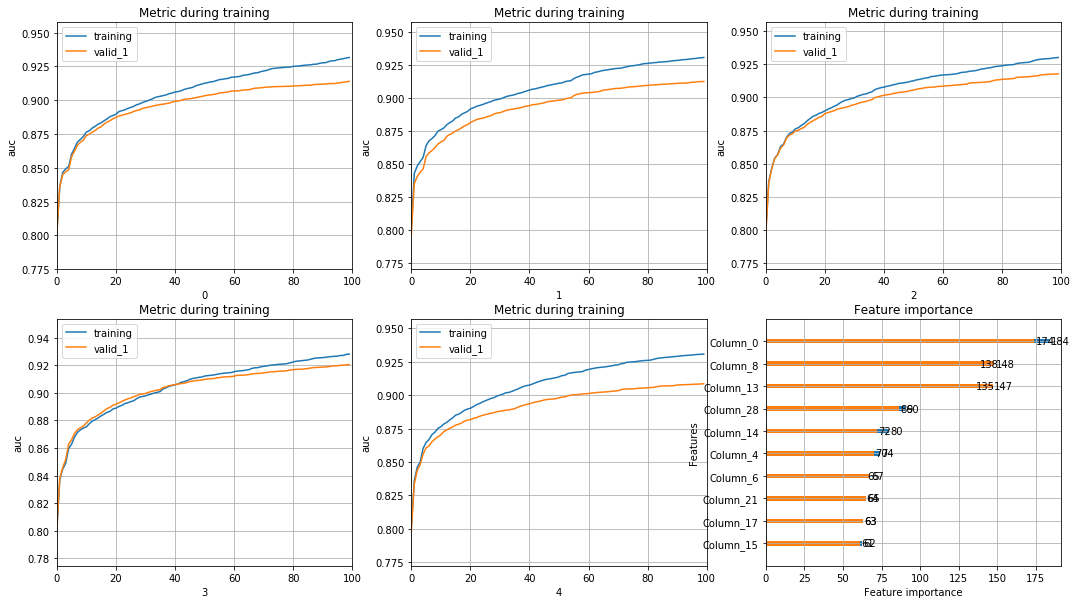

Overall scores:
  model  fold     train     valid
0   lgb     0  0.931652  0.914014
1   lgb     1  0.930748  0.912556
2   lgb     2  0.930150  0.917856
3   lgb     3  0.928185  0.920519
4   lgb     4  0.930812  0.908527
--- execution 0.82 minutes ---
Wall time: 49.6 s


In [452]:
%%time
model_name = 'lgb'
dftype = 'base'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

#  train_lgb(model_name, X_train, y_train, dftype, result_metrics)


In [453]:
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,NaN


In [454]:
%%time
# getting results from base and lgb
model_name = 'lgb'
dftype = 'base'
imp_flag = False

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)


...Loading model to predict test results for lgb base
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142534
           1       0.87      0.39      0.54      5101

    accuracy                           0.98    147635
   macro avg       0.93      0.69      0.76    147635
weighted avg       0.97      0.98      0.97    147635

confusion matrix:
[[142243    291]
 [  3126   1975]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142534
           1       0.88      0.39      0.54      5101

    accuracy                           0.98    147635
   macro avg       0.93      0.69      0.76    147635
weighted avg       0.98      0.98      0.97    147635

confusion matrix:
[[142260    274]
 [  3113   1988]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98      1.00      0.

In [455]:
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972


### ... runing base model lgbm with paramentes


FOLD # 0 
[LightGBM] [Warning] num_threads is set with n_jobs=4, nthread=4 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.901841	valid_1's auc: 0.893798
[400]	training's auc: 0.946356	valid_1's auc: 0.92006
[600]	training's auc: 0.955051	valid_1's auc: 0.925482
[800]	training's auc: 0.962579	valid_1's auc: 0.930108
[1000]	training's auc: 0.969747	valid_1's auc: 0.934618
[1200]	training's auc: 0.975002	valid_1's auc: 0.938032
[1400]	training's auc: 0.978279	valid_1's auc: 0.939591
[1600]	training's auc: 0.982198	valid_1's auc: 0.941372
[1800]	training's auc:

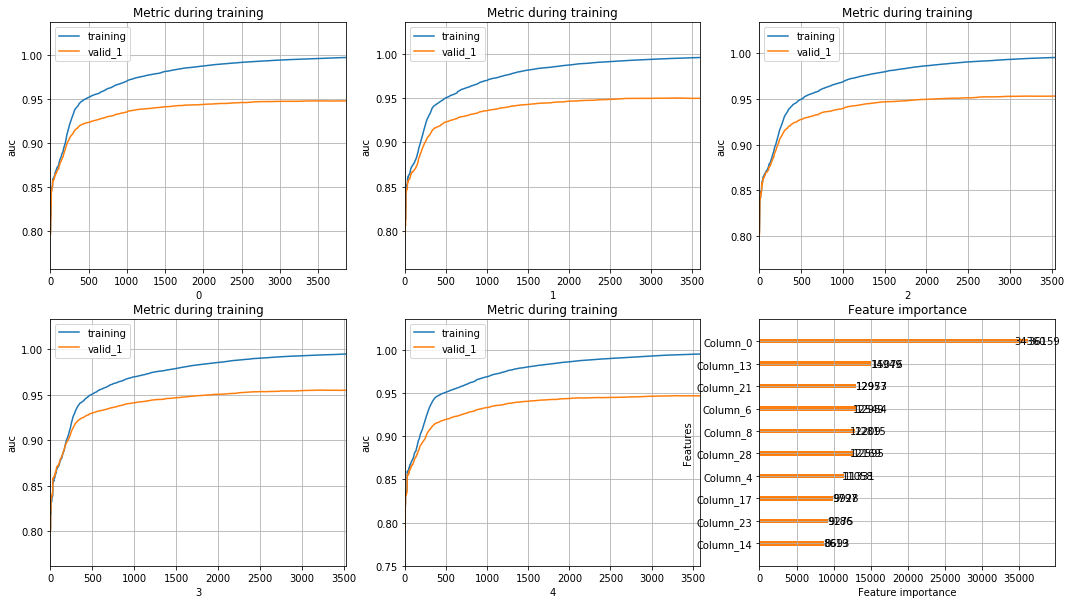

Overall scores:
       model  fold     train     valid
0  lgb_param     0  0.995744  0.947361
1  lgb_param     1  0.994630  0.949958
2  lgb_param     2  0.994468  0.953212
3  lgb_param     3  0.994010  0.955368
4  lgb_param     4  0.994392  0.947071
--- execution 24.31 minutes ---
Wall time: 24min 19s


In [456]:
%%time
model_name = 'lgb_param'
dftype = 'base'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

#### - Validating base model with testing data

In [461]:
%%time
# getting results from base_param and lgb_param
model_name = 'lgb_param'
dftype = 'base'
imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)

...Loading model to predict test results for lgb_param base
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142534
           1       0.97      0.47      0.63      5101

    accuracy                           0.98    147635
   macro avg       0.98      0.73      0.81    147635
weighted avg       0.98      0.98      0.98    147635

confusion matrix:
[[142460     74]
 [  2727   2374]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142534
           1       0.97      0.47      0.63      5101

    accuracy                           0.98    147635
   macro avg       0.98      0.73      0.81    147635
weighted avg       0.98      0.98      0.98    147635

confusion matrix:
[[142461     73]
 [  2721   2380]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98      1.00  

### ...displaying feature importance only for base with param...

Displaying feature importance...
...*** to see feature importance, open file:  lgb_param_base_feature_importance.png


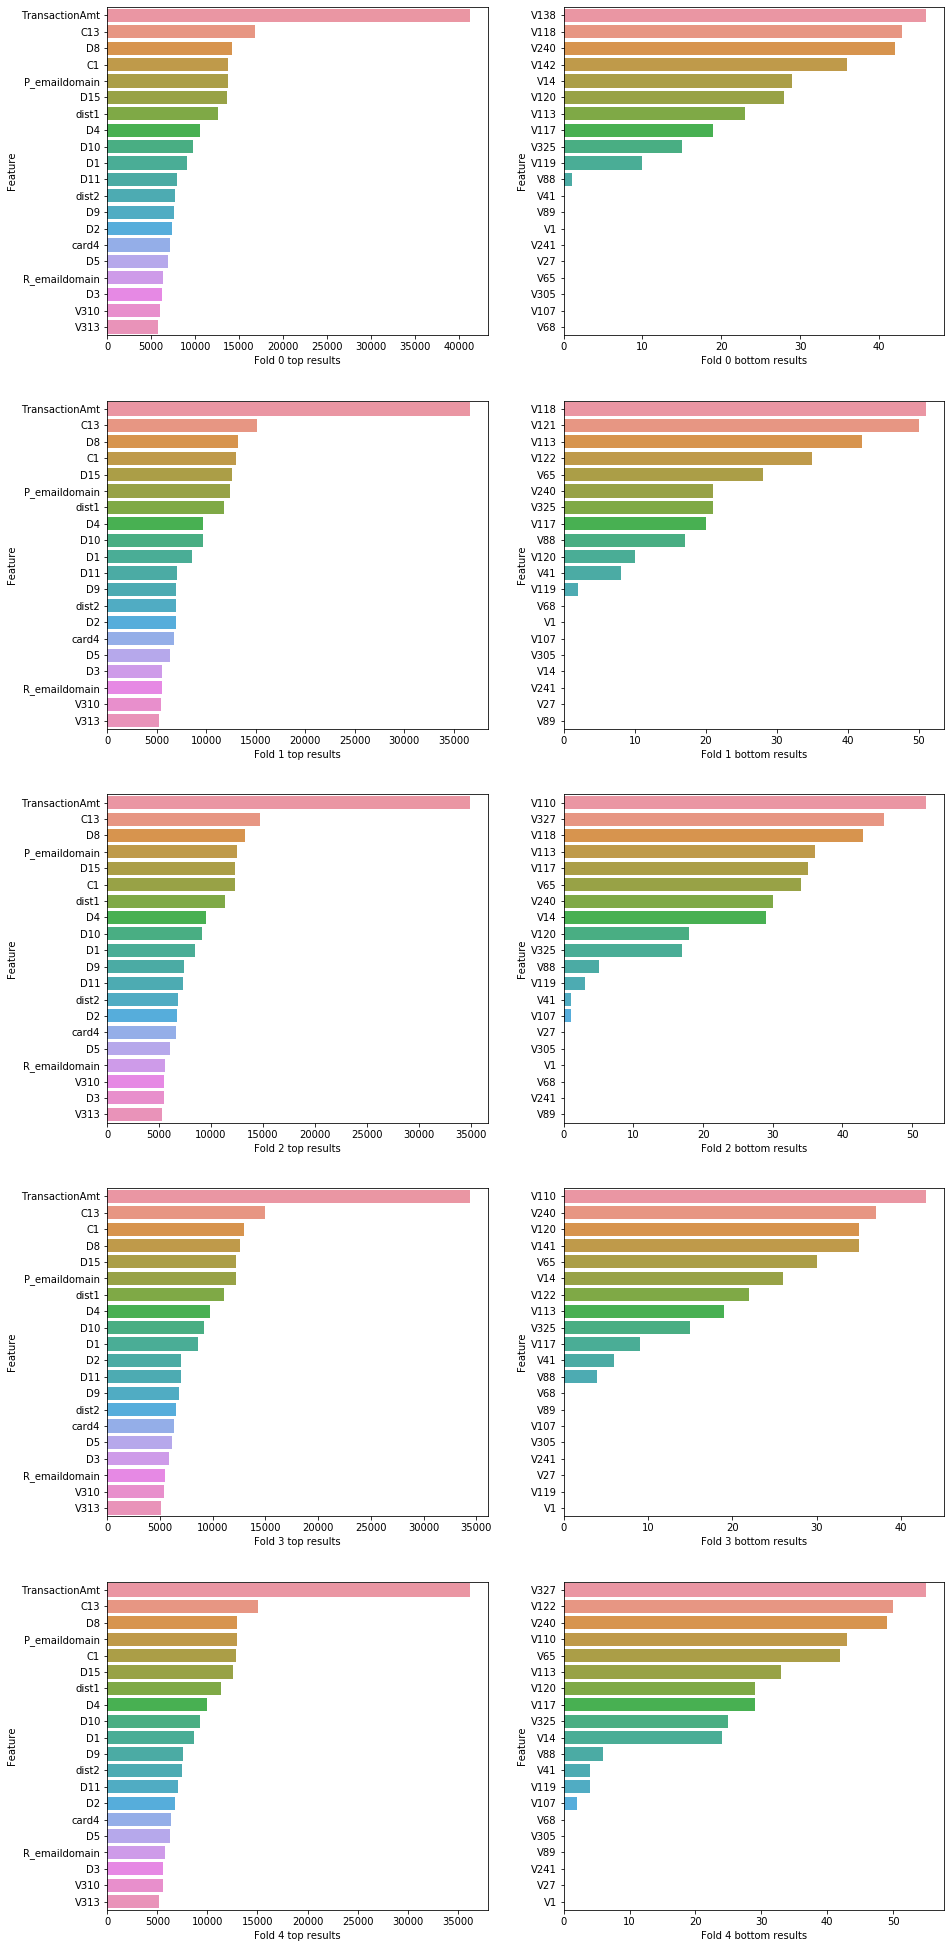

Wall time: 4.59 s


In [462]:
%%time
model_name = 'lgb_param'
dftype = 'base' 

display_feat_imp(model_name, X_train, dftype)


In [463]:
# validating test results
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972
1,base,lgb_param,0.994649,0.950594,24.311043,0.980950


#### notes:
- test accuracy was improved with lgbm parameters but at the cost of performance (24 min) of execution (exctime) time 

## 3.4 Scenario1: processing model for Trainning dataframe
- Scenario name: train_scenario1, lgbm settings: default
Notes:
- All numeric features will be included with the exception of: 
    - 'TransactionID', 'isFraud', 'card_uid','timestamp','timestmp_lag','device_detail', 'card_uid2','card_uid3','year','day'

In [464]:
# Cleaning memmory
del base_df
del y
del X
gc.collect() # garbage collection


57502

In [465]:
train_df.head(2)

,TransactionID,isFraud,TransactionAmt,ProductCD,dist1,dist2,P_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,browser,dev_mem,d_resolution,id_34,id_35,id_36,id_37,id_38,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday,timestmp_lag,24htime_lag,Region_emaildomain,device_OS,device_detail,DeviceType_Unknown,DeviceType_desktop,DeviceType_mobile
0,2987000,0,68.5,4,19.0,37.0,6,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,14,2,260,0,2,2,2,2,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01 00:00:00,2017,1,0,0,4,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0
1,2987001,0,29.0,4,8.0,37.0,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,14,2,260,0,2,2,2,2,2755-404-150-102-325-87-8-37,2755-404-150-102-325-87-8-37,2755-404-150-102,0,0,0,1,0,0,0,1,0,0,2017-12-01 00:00:01,2017,1,0,0,4,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0


In [466]:
train_features = [f for f in train_df.columns if f not in ['TransactionID', 'isFraud', 'card_uid','timestamp',\
                                                          'timestmp_lag','device_detail', 'card_uid2','card_uid3',\
                                                           'year','day']]


In [485]:
print(train_features)

['TransactionAmt', 'ProductCD', 'dist1', 'dist2', 'P_emaildomain', 'C1', 'C3', 'C5', 'C7', 'C9', 'C13', 'D1', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V15', 'V17', 'V19', 'V23', 'V24', 'V25', 'V26', 'V27', 'V29', 'V35', 'V37', 'V38', 'V39', 'V41', 'V42', 'V44', 'V46', 'V47', 'V48', 'V53', 'V55', 'V56', 'V59', 'V61', 'V62', 'V65', 'V66', 'V67', 'V68', 'V75', 'V77', 'V78', 'V80', 'V82', 'V83', 'V86', 'V87', 'V88', 'V89', 'V95', 'V98', 'V99', 'V100', 'V104', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V130', 'V131', 'V135', 'V136', 'V138', 'V139', 'V141', 'V142', 'V144', 'V146', 'V148', 'V161', 'V162', 'V165', 'V166', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V180', 'V181', 'V184', 'V185', 'V186', 'V187', 'V1

In [470]:
# choosing x and Y
y = train_df['isFraud']
X = train_df[train_features]
print (y.shape)
print (X.shape)

(590534,)
(590534, 265)


In [471]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [472]:
# we better to reindex the data
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


FOLD # 0 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.932458	training's binary_logloss: 0.0746102	valid_1's auc: 0.915922	valid_1's binary_logloss: 0.080488

FOLD # 1 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.92772	training's binary_logloss: 0.0751783	valid_1's auc: 0.914491	valid_1's binary_logloss: 0.0822714

FOLD # 2 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.931393	training's binary_logloss: 0.0749462	valid_1's auc: 0.916368	valid_1's binary_logloss: 0.0806939

FOLD # 3 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.929975	training's binary_logloss: 0.0748744	valid_1's auc: 0.914658	valid_1's binary_logloss: 0.0816573

FOLD 

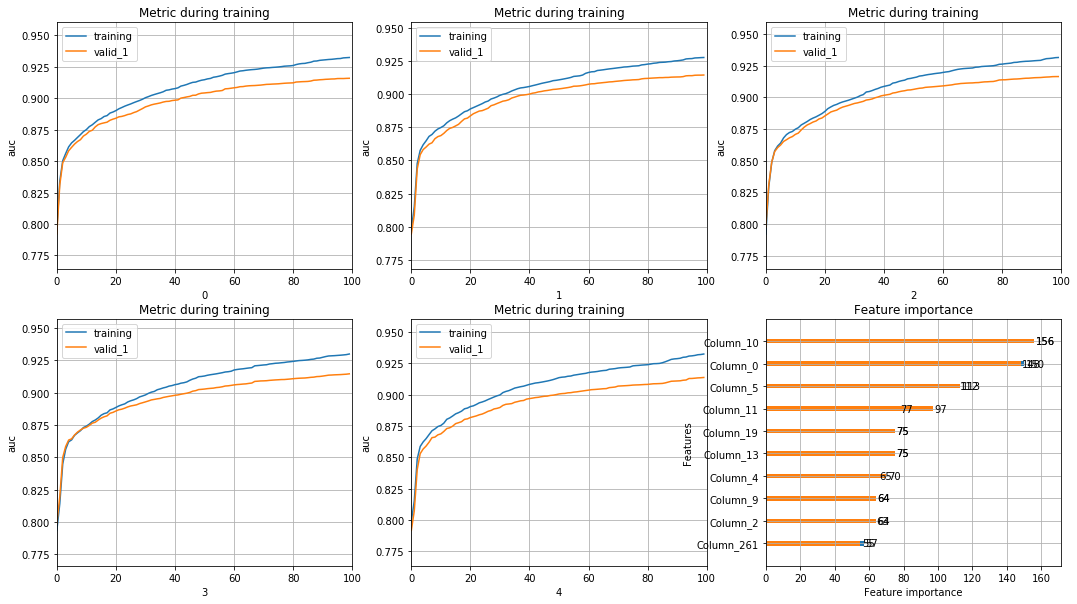

Overall scores:
  model  fold     train     valid
0   lgb     0  0.932458  0.915922
1   lgb     1  0.927720  0.914491
2   lgb     2  0.931393  0.916368
3   lgb     3  0.929975  0.914658
4   lgb     4  0.932543  0.913806
--- execution 0.79 minutes ---
Wall time: 47.6 s


In [473]:
%%time
model_name = 'lgb'
dftype = 'train_scenario1'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

#  train_lgb(model_name, X_train, y_train, dftype, result_metrics)


####  - Validating train model with testing data and Accuracy matrics:
- train_scenario1 and lgbm default (lgb)

In [475]:
%%time
# getting results from base and lgb
model_name = 'lgb'
dftype = 'train_scenario1'
# imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)


...Loading model to predict test results for lgb train_scenario1
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.89      0.40      0.56      5161

    accuracy                           0.98    147634
   macro avg       0.94      0.70      0.77    147634
weighted avg       0.98      0.98      0.97    147634

confusion matrix:
[[142220    253]
 [  3079   2082]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.88      0.40      0.55      5161

    accuracy                           0.98    147634
   macro avg       0.93      0.70      0.77    147634
weighted avg       0.98      0.98      0.97    147634

confusion matrix:
[[142192    281]
 [  3097   2064]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98      1

In [486]:
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972
1,base,lgb_param,0.994649,0.950594,24.311043,0.980950
2,train_scenario1,lgb,0.930818,0.915049,0.787731,0.977294
3,train_scenario1,lgb_param,0.998439,0.950327,24.112791,0.981095


###  processing model for Train dataframe with lgbm with param seetings: 
- Scenario name: train_scenario1 and model: lgb_param


FOLD # 0 
[LightGBM] [Warning] num_threads is set with n_jobs=4, nthread=4 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.900651	valid_1's auc: 0.892189
[400]	training's auc: 0.947049	valid_1's auc: 0.920662
[600]	training's auc: 0.958666	valid_1's auc: 0.927537
[800]	training's auc: 0.967475	valid_1's auc: 0.932913
[1000]	training's auc: 0.973314	valid_1's auc: 0.936005
[1200]	training's auc: 0.979008	valid_1's auc: 0.938402
[1400]	training's auc: 0.983063	valid_1's auc: 0.940447
[1600]	training's auc: 0.986715	valid_1's auc: 0.942299
[1800]	training's auc

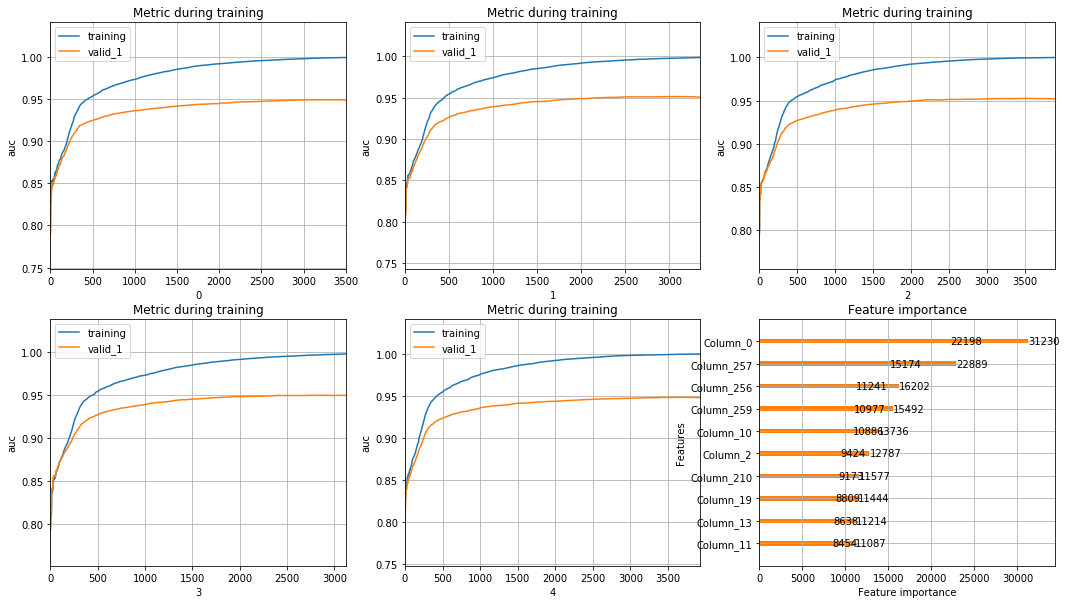

Overall scores:
       model  fold     train     valid
0  lgb_param     0  0.998552  0.949197
1  lgb_param     1  0.997825  0.951474
2  lgb_param     2  0.999392  0.952414
3  lgb_param     3  0.997146  0.950242
4  lgb_param     4  0.999279  0.948309
--- execution 24.11 minutes ---
Wall time: 24min 7s


In [477]:
%%time
model_name = 'lgb_param'
dftype = 'train_scenario1'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

In [478]:
%%time
# getting results from base and lgb
model_name = 'lgb_param'
dftype = 'train_scenario1'
# imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)

...Loading model to predict test results for lgb_param train_scenario1
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.98      0.46      0.63      5161

    accuracy                           0.98    147634
   macro avg       0.98      0.73      0.81    147634
weighted avg       0.98      0.98      0.98    147634

confusion matrix:
[[142435     38]
 [  2778   2383]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.98      0.47      0.63      5161

    accuracy                           0.98    147634
   macro avg       0.98      0.73      0.81    147634
weighted avg       0.98      0.98      0.98    147634

confusion matrix:
[[142431     42]
 [  2757   2404]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98 

### ...displaying feature importance only for base with param...

Displaying feature importance...
...*** to see feature importance, open file:  lgb_param_train_scenario1_feature_importance.png


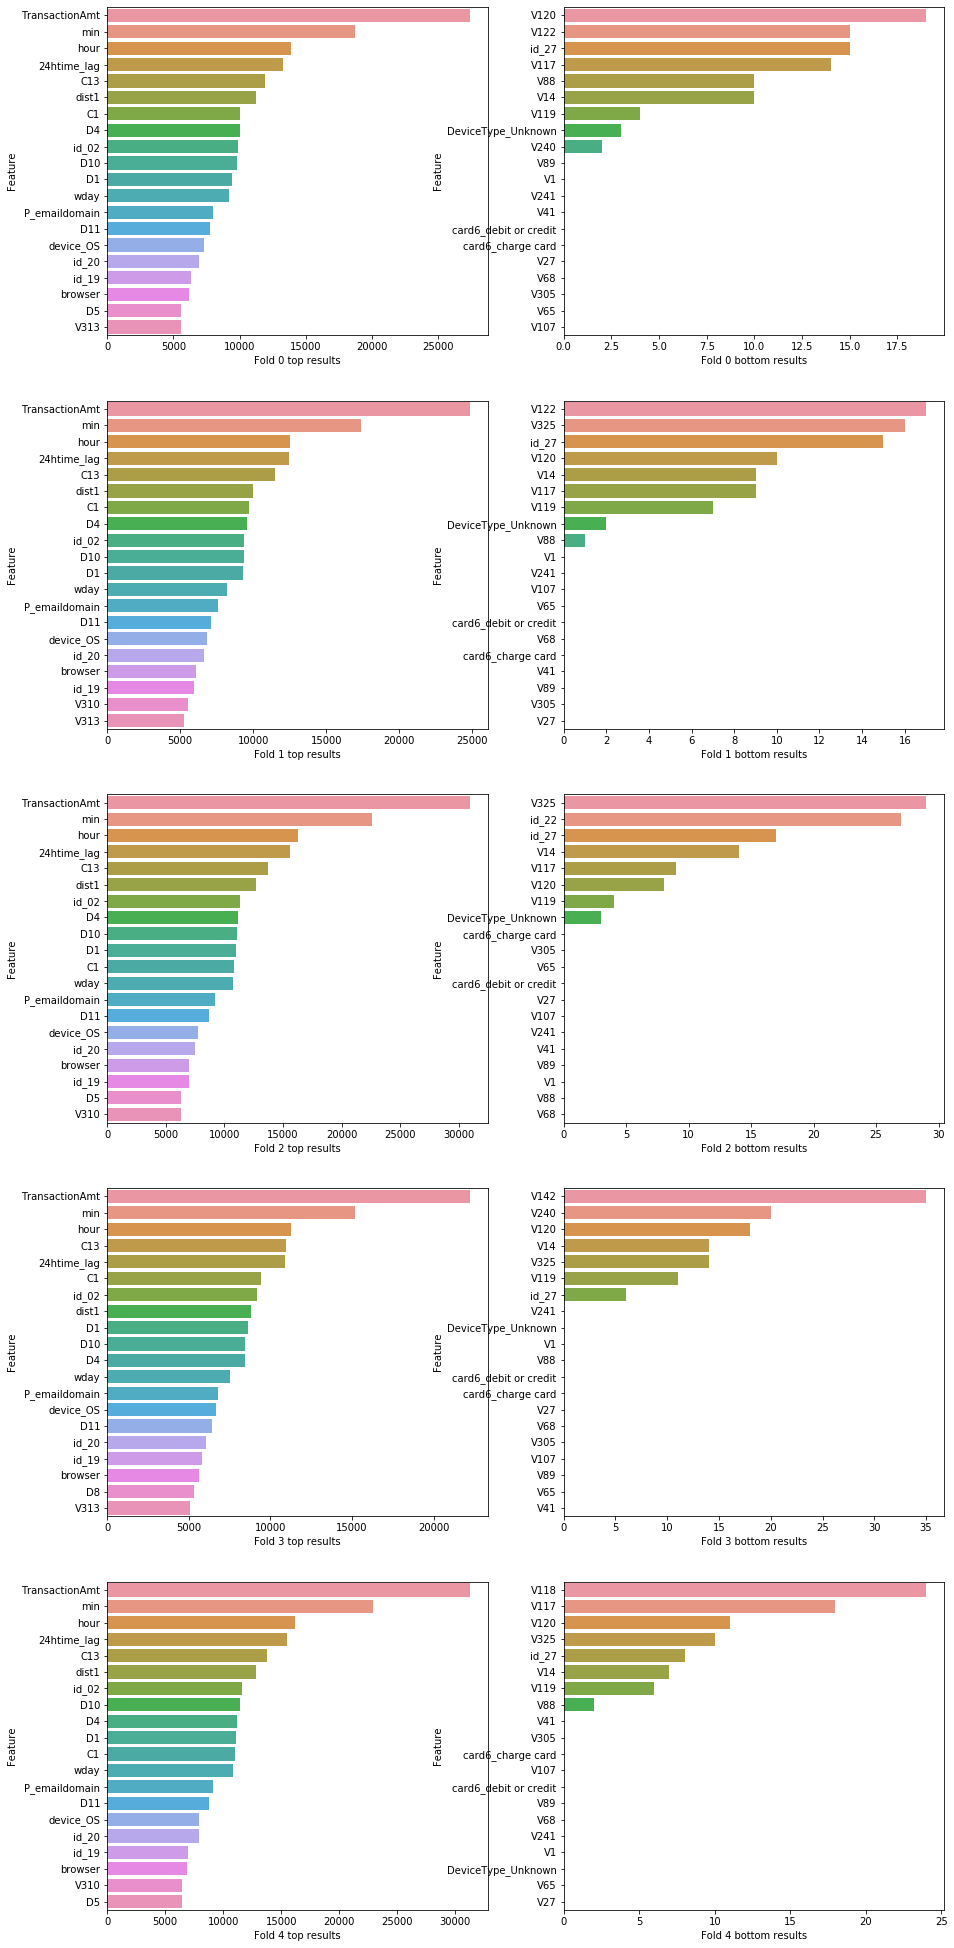

In [483]:
model_name = 'lgb_param'
dftype = 'train_scenario1' 

display_feat_imp(model_name, X_train, dftype)


In [484]:
# validating test results
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972
1,base,lgb_param,0.994649,0.950594,24.311043,0.980950
2,train_scenario1,lgb,0.930818,0.915049,0.787731,0.977294
3,train_scenario1,lgb_param,0.998439,0.950327,24.112791,0.981095


####  conclusion:
- The Model shown better accuracy with Train data...see if the model can improve by removing o ranked features and keeping only 24htime_lag time feature 

## 3.5 Scenario 2: Train data without low feature ranking and only with 24htimelag: train_scenario1

In [487]:
train_df.head(2)

,TransactionID,isFraud,TransactionAmt,ProductCD,dist1,dist2,P_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,browser,dev_mem,d_resolution,id_34,id_35,id_36,id_37,id_38,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday,timestmp_lag,24htime_lag,Region_emaildomain,device_OS,device_detail,DeviceType_Unknown,DeviceType_desktop,DeviceType_mobile
0,2987000,0,68.5,4,19.0,37.0,6,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,14,2,260,0,2,2,2,2,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01 00:00:00,2017,1,0,0,4,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0
1,2987001,0,29.0,4,8.0,37.0,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,10.0,0.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,14,2,260,0,2,2,2,2,2755-404-150-102-325-87-8-37,2755-404-150-102-325-87-8-37,2755-404-150-102,0,0,0,1,0,0,0,1,0,0,2017-12-01 00:00:01,2017,1,0,0,4,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0


In [493]:
# updating feature list: removing date and time information and lower ranked feature importance...keeping 24htimelag 
train_features = [f for f in train_df.columns if f not in \
                  ['TransactionID', 'isFraud', 'card_uid','card_uid2', 'card_uid3', 'timestamp','timestmp_lag','device_detail', \
                   'year','day','hour','min', 'V1', 'V27', 'V41', 'V65', 'V68', 'V88', 'V89', 'V107','V240',\
                   'V241', 'V305', 'card6_charge card', 'card6_debit or credit']]

print(train_features)


['TransactionAmt', 'ProductCD', 'dist1', 'dist2', 'P_emaildomain', 'C1', 'C3', 'C5', 'C7', 'C9', 'C13', 'D1', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V15', 'V17', 'V19', 'V23', 'V24', 'V25', 'V26', 'V29', 'V35', 'V37', 'V38', 'V39', 'V42', 'V44', 'V46', 'V47', 'V48', 'V53', 'V55', 'V56', 'V59', 'V61', 'V62', 'V66', 'V67', 'V75', 'V77', 'V78', 'V80', 'V82', 'V83', 'V86', 'V87', 'V95', 'V98', 'V99', 'V100', 'V104', 'V108', 'V109', 'V110', 'V111', 'V112', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V130', 'V131', 'V135', 'V136', 'V138', 'V139', 'V141', 'V142', 'V144', 'V146', 'V148', 'V161', 'V162', 'V165', 'V166', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V180', 'V181', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V191', 'V194', 'V195', 'V200', 'V205', 'V2

In [494]:
# choosing x and Y
y = train_df['isFraud']
X = train_df[train_features]
print (y.shape)
print (X.shape)

(590534,)
(590534, 250)


In [495]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [496]:
# we better to reindex the data
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


FOLD # 0 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.93281	training's binary_logloss: 0.0747497	valid_1's auc: 0.915604	valid_1's binary_logloss: 0.0809044

FOLD # 1 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.930171	training's binary_logloss: 0.0747188	valid_1's auc: 0.916182	valid_1's binary_logloss: 0.0819694

FOLD # 2 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.93024	training's binary_logloss: 0.0749555	valid_1's auc: 0.916141	valid_1's binary_logloss: 0.0804887

FOLD # 3 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.930911	training's binary_logloss: 0.0748599	valid_1's auc: 0.916641	valid_1's binary_logloss: 0.0813328

FOLD 

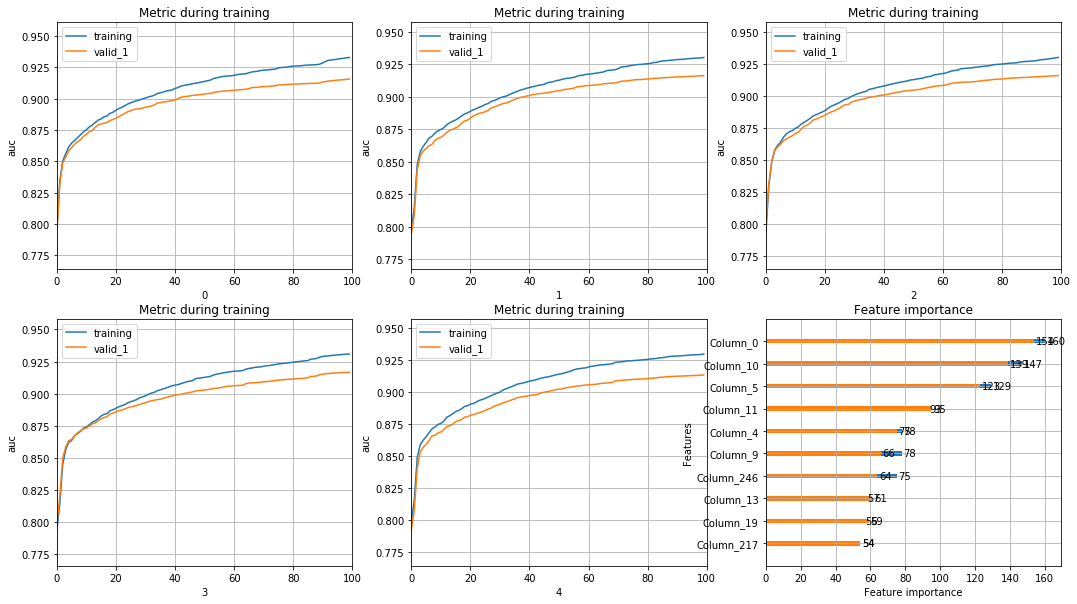

Overall scores:
  model  fold     train     valid
0   lgb     0  0.932810  0.915604
1   lgb     1  0.930171  0.916182
2   lgb     2  0.930240  0.916141
3   lgb     3  0.930911  0.916641
4   lgb     4  0.929895  0.913598
--- execution 0.79 minutes ---
Wall time: 47.9 s


In [497]:
%%time
model_name = 'lgb'
dftype = 'train_scenario2'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

In [498]:
%%time
# getting results from base_param and lgb_param
model_name = 'lgb'
dftype = 'train_scenario2'
imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)

...Loading model to predict test results for lgb train_scenario2
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.89      0.40      0.55      5161

    accuracy                           0.98    147634
   macro avg       0.93      0.70      0.77    147634
weighted avg       0.98      0.98      0.97    147634

confusion matrix:
[[142206    267]
 [  3100   2061]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.88      0.40      0.55      5161

    accuracy                           0.98    147634
   macro avg       0.93      0.70      0.77    147634
weighted avg       0.98      0.98      0.97    147634

confusion matrix:
[[142198    275]
 [  3078   2083]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98      1

In [499]:
# validating test results
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972
1,base,lgb_param,0.994649,0.950594,24.311043,0.980950
2,train_scenario1,lgb,0.930818,0.915049,0.787731,0.977294
3,train_scenario1,lgb_param,0.998439,0.950327,24.112791,0.981095
4,train_scenario2,lgb,0.930805,0.915633,0.792390,0.977356


### ... Running Scenario 2 with lgbm parameter setting


FOLD # 0 
[LightGBM] [Warning] num_threads is set with n_jobs=4, nthread=4 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.900529	valid_1's auc: 0.891259
[400]	training's auc: 0.94686	valid_1's auc: 0.921941
[600]	training's auc: 0.95789	valid_1's auc: 0.928843
[800]	training's auc: 0.966097	valid_1's auc: 0.933727
[1000]	training's auc: 0.971564	valid_1's auc: 0.936563
[1200]	training's auc: 0.976912	valid_1's auc: 0.939155
[1400]	training's auc: 0.980904	valid_1's auc: 0.941808
[1600]	training's auc: 0.984772	valid_1's auc: 0.943797
[1800]	training's auc: 

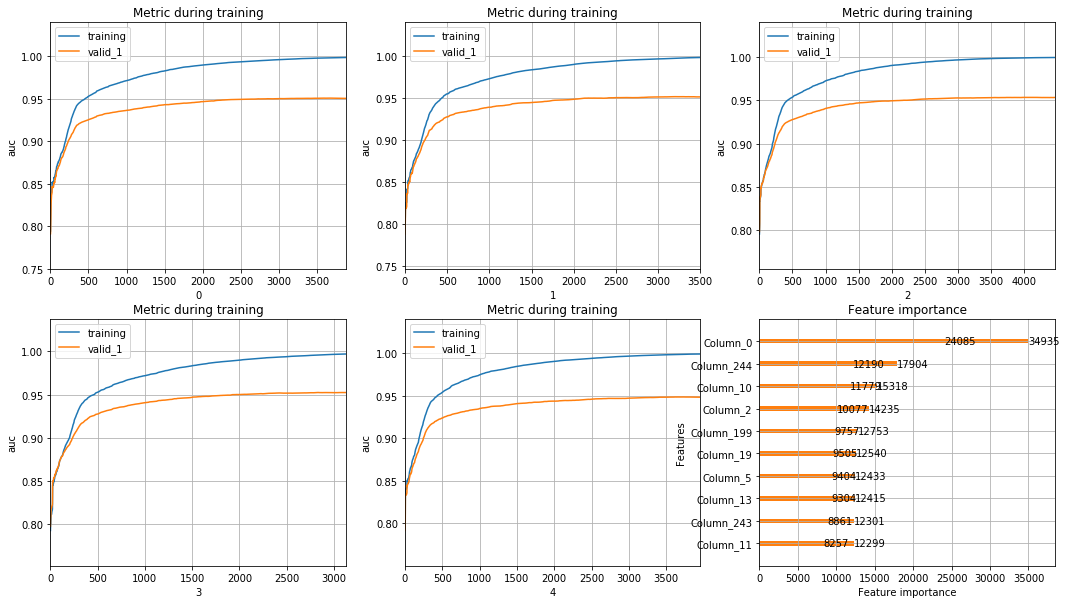

Overall scores:
       model  fold     train     valid
0  lgb_param     0  0.998230  0.951008
1  lgb_param     1  0.997170  0.951386
2  lgb_param     2  0.999315  0.953543
3  lgb_param     3  0.995908  0.952381
4  lgb_param     4  0.998346  0.948428
--- execution 26.05 minutes ---
Wall time: 26min 3s


In [500]:
%%time
model_name = 'lgb_param'
dftype = 'train_scenario2'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )


In [501]:
%%time
# getting results from base_param and lgb_param
model_name = 'lgb_param'
dftype = 'train_scenario2'
imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)

...Loading model to predict test results for lgb_param train_scenario2
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.98      0.48      0.65      5161

    accuracy                           0.98    147634
   macro avg       0.98      0.74      0.82    147634
weighted avg       0.98      0.98      0.98    147634

confusion matrix:
[[142428     45]
 [  2675   2486]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.98      0.48      0.64      5161

    accuracy                           0.98    147634
   macro avg       0.98      0.74      0.82    147634
weighted avg       0.98      0.98      0.98    147634

confusion matrix:
[[142427     46]
 [  2703   2458]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98 

Displaying feature importance...
...*** to see feature importance, open file:  lgb_param_train_scenario2_feature_importance.png


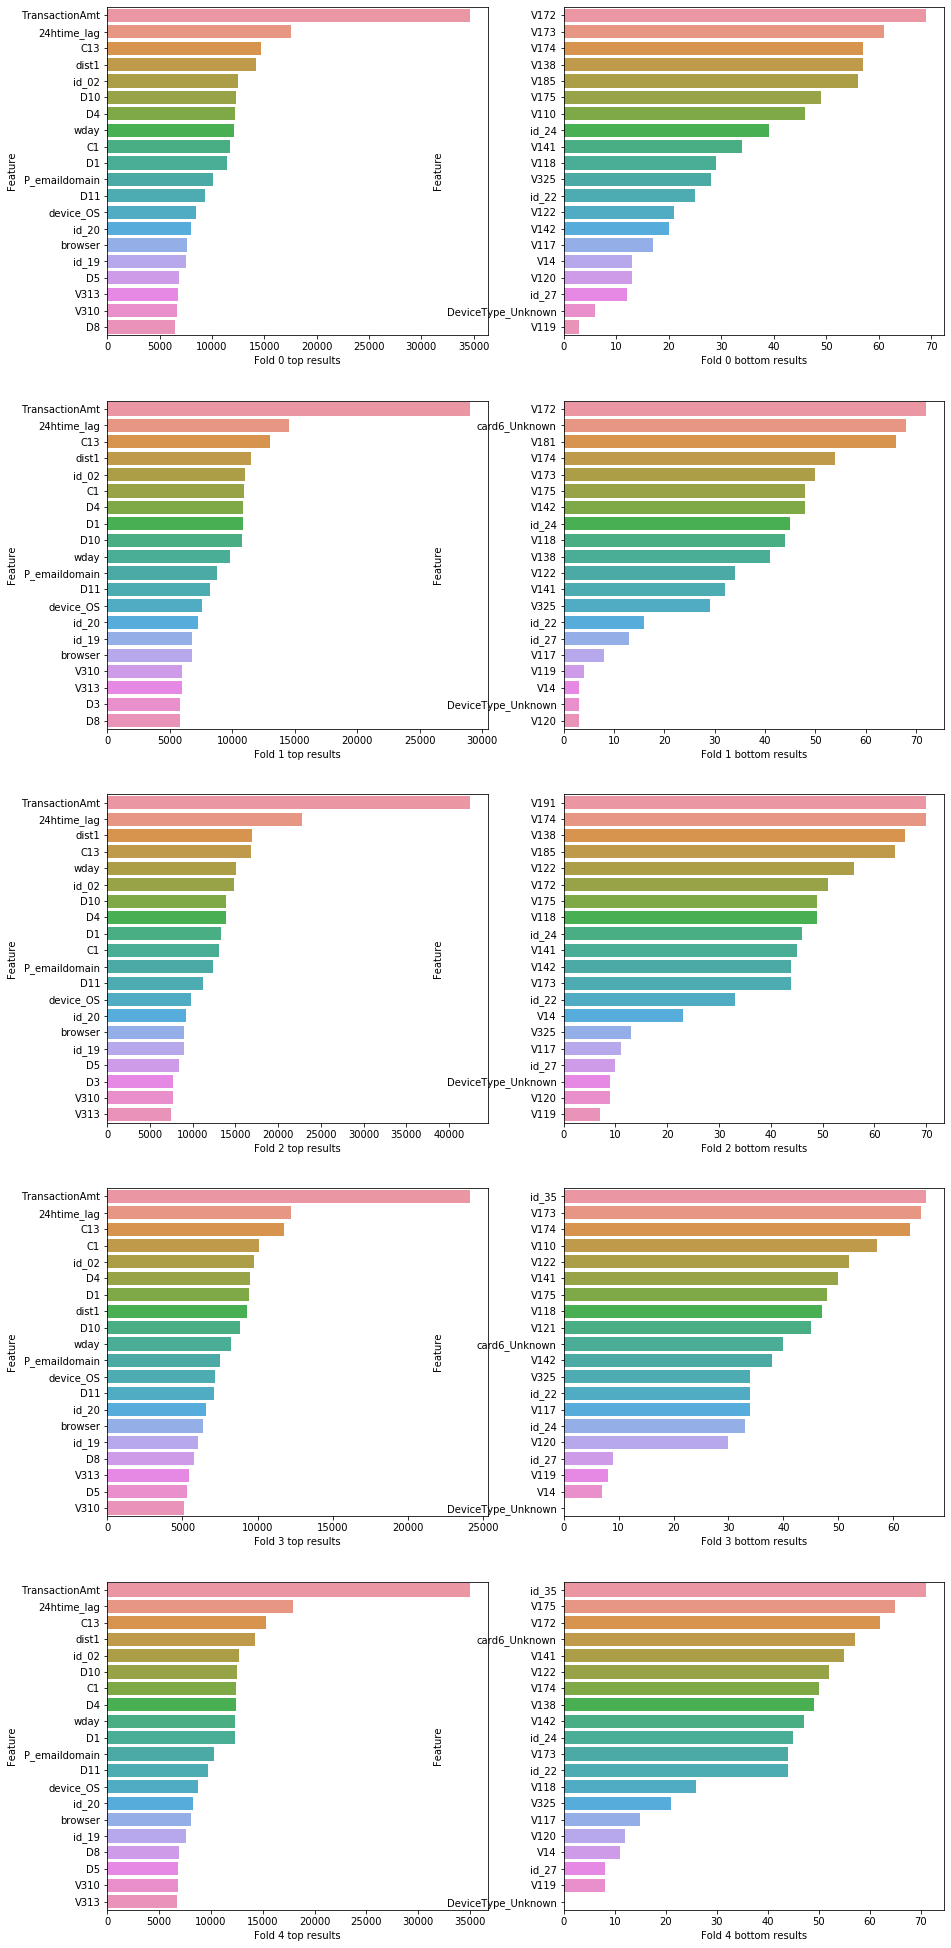

In [502]:
# calling function to display feature importance
model_name = 'lgb_param'
dftype = 'train_scenario2'

display_feat_imp(model_name, X_train, dftype)




In [503]:
result_metrics.head()

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972
1,base,lgb_param,0.994649,0.950594,24.311043,0.980950
2,train_scenario1,lgb,0.930818,0.915049,0.787731,0.977294
3,train_scenario1,lgb_param,0.998439,0.950327,24.112791,0.981095
4,train_scenario2,lgb,0.930805,0.915633,0.792390,0.977356


## 3.6 Scenario 3: Train dataframe and aggreting the Transaction amount
- Scenario name: train_scenario3, with model lbgm-dafalt(lgb) and lgbm_param (lgbm with parameters)
- Features: aggregating Transaction amount and exluding bottom 10 ranked features from scenario 2 feature importance

In [514]:
train_df.head(1)

,TransactionID,isFraud,TransactionAmt,ProductCD,dist1,dist2,P_emaildomain,C1,C3,C5,C7,C9,C13,D1,D3,D4,D5,D6,D7,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V6,V7,V8,V9,V10,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V35,V37,V38,V39,V41,V42,V44,V46,V47,V48,V53,V55,V56,V59,V61,V62,V65,V66,V67,V68,V75,V77,V78,V80,V82,V83,V86,V87,V88,V89,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V138,V139,V141,V142,V144,V146,V148,V161,V162,V165,V166,V169,V170,V171,V172,V173,V174,V175,V176,V180,V181,V184,V185,V186,V187,V188,V189,V191,V194,V195,V200,V205,V206,V208,V209,V210,V214,V215,V217,V220,V221,V223,V224,V226,V227,V228,V229,V230,V234,V235,V238,V240,V241,V242,V245,V246,V247,V248,V250,V252,V255,V258,V260,V261,V262,V263,V264,V267,V268,V270,V276,V277,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V302,V303,V305,V310,V311,V312,V313,V314,V319,V320,V325,V326,V335,V337,V338,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,browser,dev_mem,d_resolution,id_34,id_35,id_36,id_37,id_38,card_uid,card_uid2,card_uid3,card4_Unknown,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_Unknown,card6_charge card,card6_credit,card6_debit,card6_debit or credit,timestamp,year,day,hour,min,wday,timestmp_lag,24htime_lag,Region_emaildomain,device_OS,device_detail,DeviceType_Unknown,DeviceType_desktop,DeviceType_mobile
0,2987000,0,68.5,4,19.0,37.0,6,1.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,14,2,260,0,2,2,2,2,13926-361-150-142-315-87-19-37,13926-361-150-142-315-87-19-37,13926-361-150-142,0,0,1,0,0,0,0,1,0,0,2017-12-01,2017,1,0,0,4,0 days,0.0,7,2043,Unknown-Unknown-Unknown-Unknown,1,0,0


### ... Agg the transaction Amount field (TransactionAmt)

In [511]:
agg_dict = {
    'TransactionAmt':['mean','median','max','min','std']
}

In [513]:
agged_df = train_df.groupby('card_uid').agg(agg_dict)
agged_df.columns = ['{}_{}'.format(f[0],f[1]) for f in agged_df.columns]
agged_df.head()

,TransactionAmt_mean,TransactionAmt_median,TransactionAmt_max,TransactionAmt_min,TransactionAmt_std
card_uid,,,,,
1000-555-185-224-299-87-8-37,23.43750,23.43750,23.43750,23.437500,NaN
10000-111-150-117-184-87-8-37,29.00000,29.00000,29.00000,29.000000,NaN
10003-361-150-226-299-87-8-37,42.78125,42.78125,42.78125,42.781250,NaN
10003-555-128-226-299-87-8-37,22.09375,19.09375,39.40625,10.757812,12.195312
10004-529-150-162-123-87-8-37,1576.00000,1576.00000,1576.00000,1576.000000,NaN


In [516]:
agged_df.isnull().sum()

TransactionAmt_mean          0
TransactionAmt_median        0
TransactionAmt_max           0
TransactionAmt_min           0
TransactionAmt_std       66476
dtype: int64

In [517]:
agged_df['TransactionAmt_std'] = agged_df['TransactionAmt_std'].fillna(agged_df['TransactionAmt_std'].median())

In [518]:
agged_df.isnull().sum()

TransactionAmt_mean      0
TransactionAmt_median    0
TransactionAmt_max       0
TransactionAmt_min       0
TransactionAmt_std       0
dtype: int64

In [520]:
print(train_df.shape)
train_df = train_df.merge(agged_df,on='card_uid',how='left')
print(train_df.shape)

(590534, 275)
(590534, 280)


In [525]:
train_df.isnull().sum().sum()

0

In [528]:
train_df[['TransactionAmt_mean','TransactionAmt_median','TransactionAmt_max','TransactionAmt_min','TransactionAmt_std']].head()

,TransactionAmt_mean,TransactionAmt_median,TransactionAmt_max,TransactionAmt_min,TransactionAmt_std
0,68.500,68.5,68.5,68.5,35.34375
1,381.250,93.5,4592.0,29.0,inf
2,73.500,71.5,92.0,59.0,17.06250
3,128.125,77.0,3190.0,15.0,inf
4,50.000,50.0,50.0,50.0,35.34375


In [531]:
train_features = [f for f in train_df.columns if f not in \
                  ['TransactionID', 'isFraud', 'card_uid','card_uid2', 'card_uid3', 'timestamp','timestmp_lag','device_detail', \
                   'year','day','hour','min', 'V1', 'V27', 'V41', 'V65', 'V68', 'V88', 'V89', 'V107','V240',\
                   'V241', 'V305', 'card6_charge card', 'card6_debit or credit', 'DeviceType_Unknown', 'V142', 'V325',\
                  'V117','V120','V119','id_22','id_24','id_27' ]]

In [532]:
print(train_features)

['TransactionAmt', 'ProductCD', 'dist1', 'dist2', 'P_emaildomain', 'C1', 'C3', 'C5', 'C7', 'C9', 'C13', 'D1', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V15', 'V17', 'V19', 'V23', 'V24', 'V25', 'V26', 'V29', 'V35', 'V37', 'V38', 'V39', 'V42', 'V44', 'V46', 'V47', 'V48', 'V53', 'V55', 'V56', 'V59', 'V61', 'V62', 'V66', 'V67', 'V75', 'V77', 'V78', 'V80', 'V82', 'V83', 'V86', 'V87', 'V95', 'V98', 'V99', 'V100', 'V104', 'V108', 'V109', 'V110', 'V111', 'V112', 'V114', 'V115', 'V116', 'V118', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V130', 'V131', 'V135', 'V136', 'V138', 'V139', 'V141', 'V144', 'V146', 'V148', 'V161', 'V162', 'V165', 'V166', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V180', 'V181', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V191', 'V194', 'V195', 'V200', 'V205', 'V206', 'V208', 'V209', 'V210', 'V2

In [533]:
# choosing x and Y
y = train_df['isFraud']
X = train_df[train_features]
print (y.shape)
print (X.shape)

(590534,)
(590534, 246)


In [534]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [535]:
# we better to reindex the data
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)



FOLD # 0 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.935069	training's binary_logloss: 0.0735468	valid_1's auc: 0.917881	valid_1's binary_logloss: 0.080196

FOLD # 1 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.935034	training's binary_logloss: 0.0733548	valid_1's auc: 0.921376	valid_1's binary_logloss: 0.0804098

FOLD # 2 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.934878	training's binary_logloss: 0.0734801	valid_1's auc: 0.920836	valid_1's binary_logloss: 0.0789068

FOLD # 3 
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.936207	training's binary_logloss: 0.073219	valid_1's auc: 0.919975	valid_1's binary_logloss: 0.0803442

FOLD 

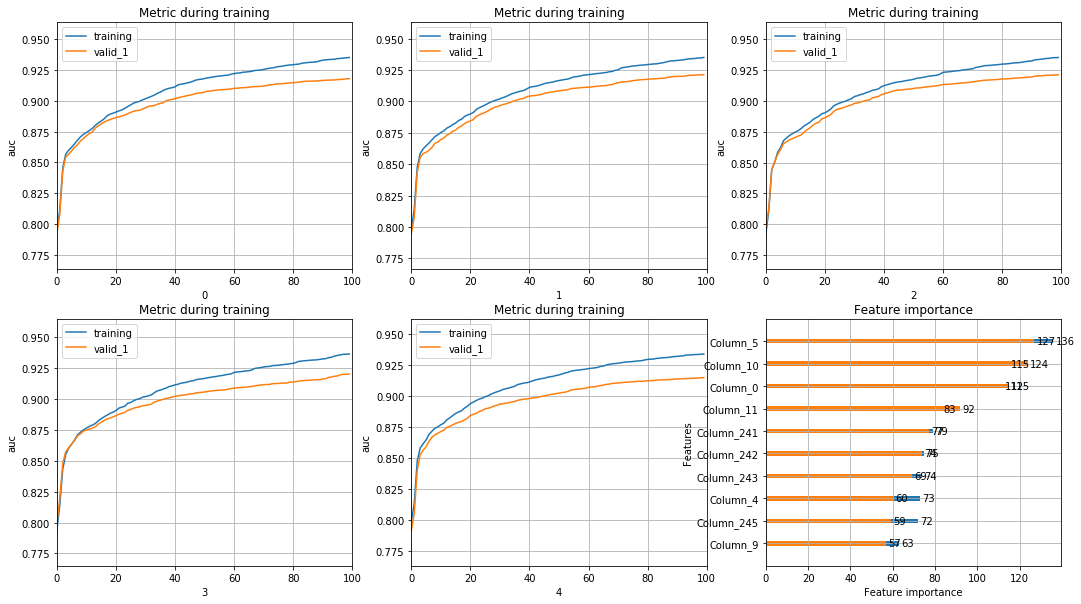

Overall scores:
  model  fold     train     valid
0   lgb     0  0.935069  0.917881
1   lgb     1  0.935034  0.921376
2   lgb     2  0.934878  0.920836
3   lgb     3  0.936207  0.919975
4   lgb     4  0.933982  0.914993
--- execution 0.76 minutes ---
Wall time: 46 s


In [536]:
%%time
model_name = 'lgb'
dftype = 'train_scenario3'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

In [537]:
%%time
# getting results from base_param and lgb_param
model_name = 'lgb'
dftype = 'train_scenario3'
imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)


...Loading model to predict test results for lgb train_scenario3
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.89      0.40      0.56      5161

    accuracy                           0.98    147634
   macro avg       0.93      0.70      0.77    147634
weighted avg       0.98      0.98      0.97    147634

confusion matrix:
[[142216    257]
 [  3075   2086]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.89      0.41      0.56      5161

    accuracy                           0.98    147634
   macro avg       0.93      0.70      0.77    147634
weighted avg       0.98      0.98      0.97    147634

confusion matrix:
[[142212    261]
 [  3063   2098]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98      1

In [538]:
### ... runing Scenario 3 for lgbm with param


FOLD # 0 
[LightGBM] [Warning] num_threads is set with n_jobs=4, nthread=4 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.904125	valid_1's auc: 0.894936
[400]	training's auc: 0.952907	valid_1's auc: 0.927954
[600]	training's auc: 0.964615	valid_1's auc: 0.935926
[800]	training's auc: 0.972505	valid_1's auc: 0.941297
[1000]	training's auc: 0.979008	valid_1's auc: 0.944959
[1200]	training's auc: 0.984127	valid_1's auc: 0.948319
[1400]	training's auc: 0.987699	valid_1's auc: 0.950797
[1600]	training's auc: 0.990958	valid_1's auc: 0.953185
[1800]	training's auc

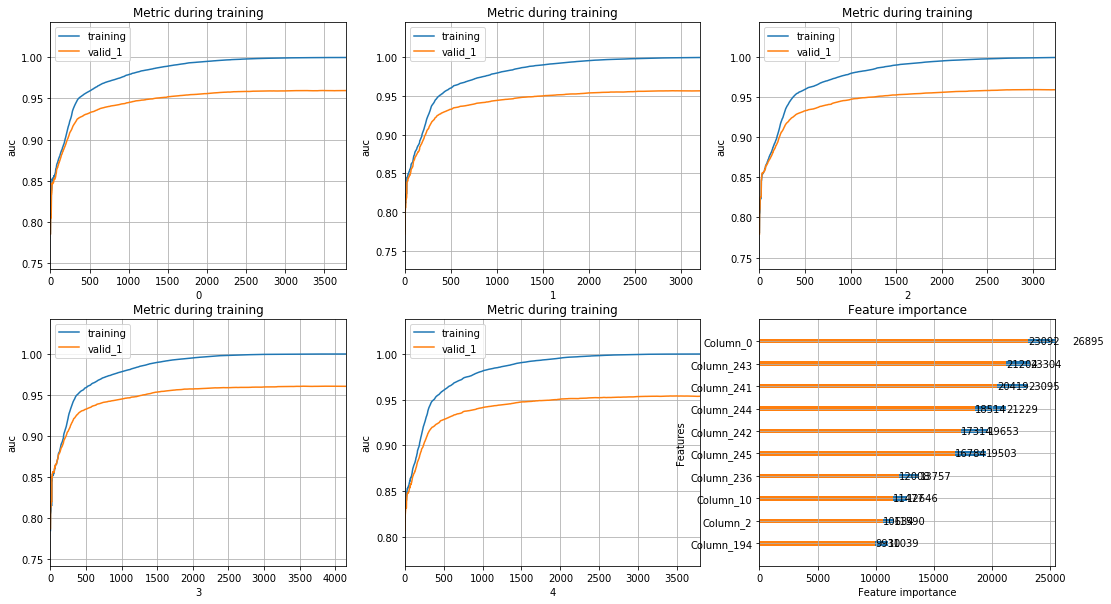

Overall scores:
       model  fold     train     valid
0  lgb_param     0  0.999863  0.959706
1  lgb_param     1  0.999327  0.956727
2  lgb_param     2  0.999410  0.959746
3  lgb_param     3  0.999964  0.960653
4  lgb_param     4  0.999906  0.954025
--- execution 24.87 minutes ---
Wall time: 24min 52s


In [539]:
%%time
model_name = 'lgb_param'
dftype = 'train_scenario3'

result_metrics = train_lgb(model_name = model_name, X_train = X_train.to_numpy(), y_train = y_train.to_numpy(), dftype = dftype , \
          result_metrics = result_metrics )

In [540]:
%%time
# getting results from base_param and lgb_param
model_name = 'lgb_param'
dftype = 'train_scenario3'
imp_flag = True

result_metrics = print_results(X_test, y_test, model_name, dftype, result_metrics)

...Loading model to predict test results for lgb_param train_scenario3
lgb model results for kfold 0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.98      0.50      0.66      5161

    accuracy                           0.98    147634
   macro avg       0.98      0.75      0.83    147634
weighted avg       0.98      0.98      0.98    147634

confusion matrix:
[[142426     47]
 [  2571   2590]]
lgb model results for kfold 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142473
           1       0.98      0.49      0.66      5161

    accuracy                           0.98    147634
   macro avg       0.98      0.75      0.82    147634
weighted avg       0.98      0.98      0.98    147634

confusion matrix:
[[142434     39]
 [  2620   2541]]
lgb model results for kfold 2
              precision    recall  f1-score   support

           0       0.98 

Displaying feature importance...
...*** to see feature importance, open file:  lgb_param_train_scenario3_feature_importance.png


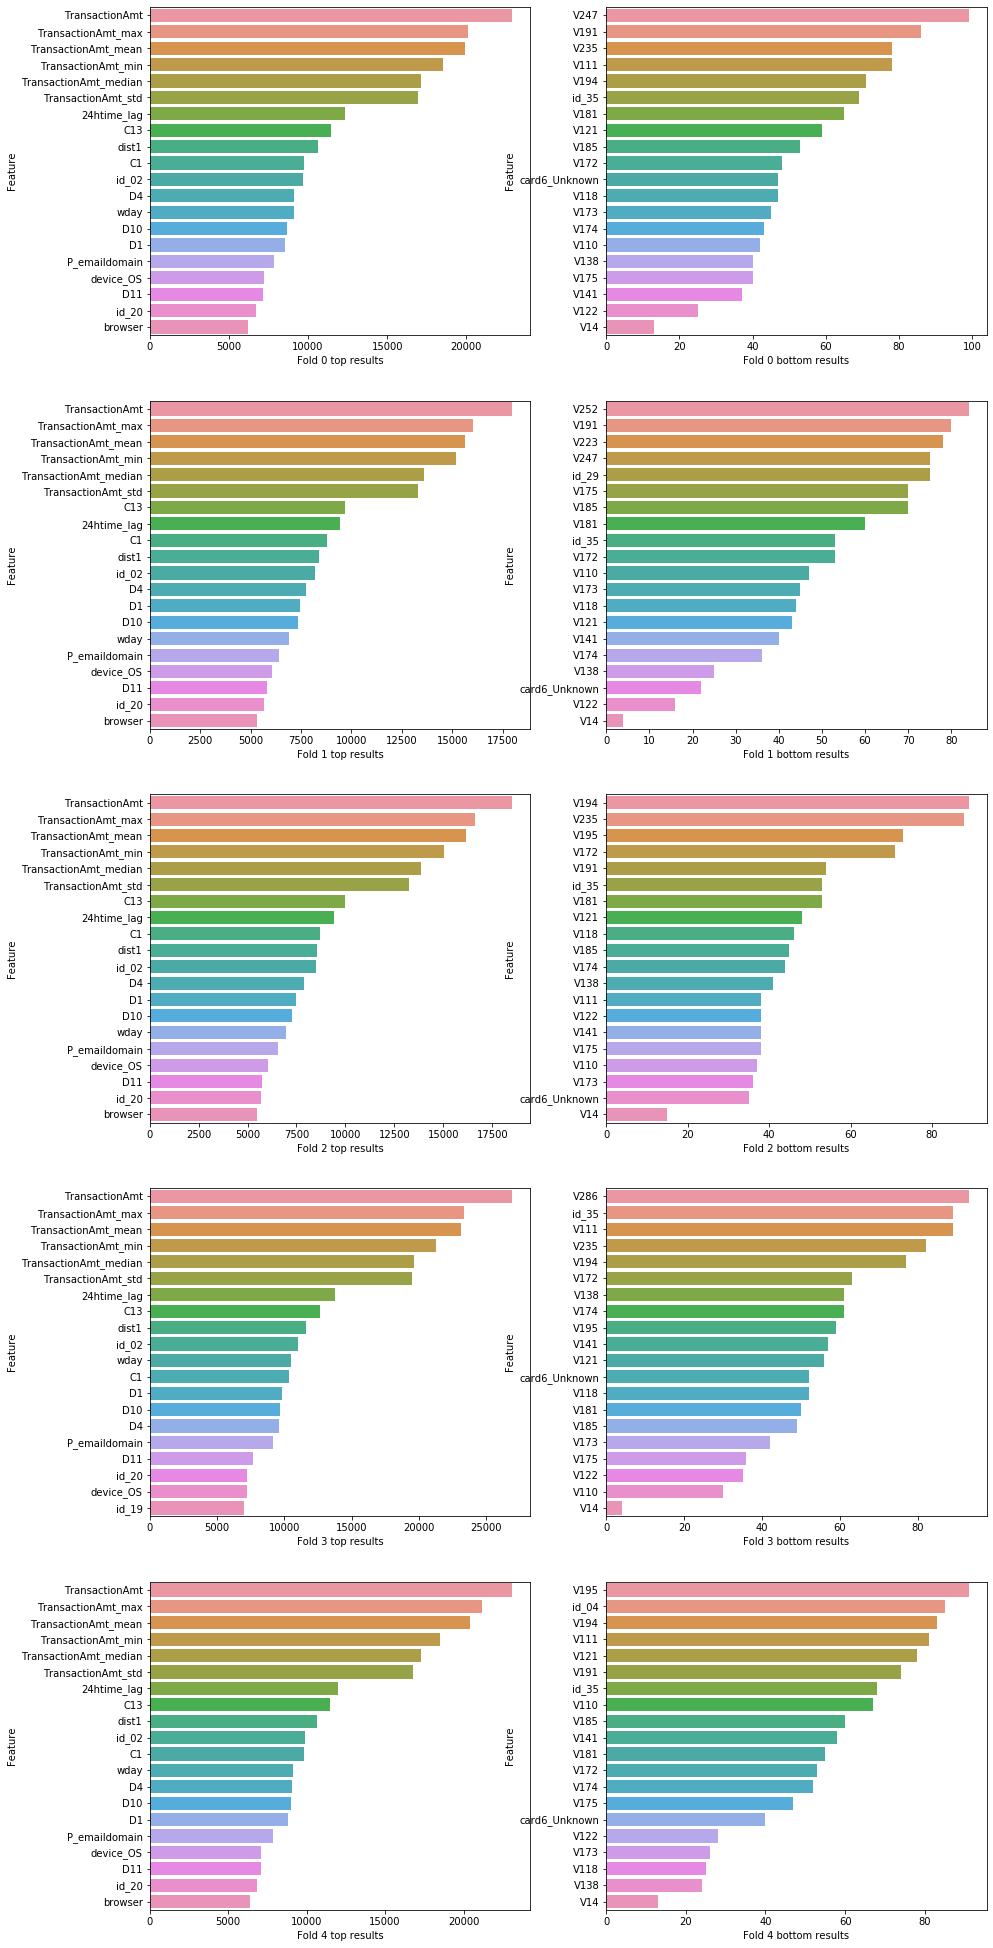

In [542]:
# calling function to display feature importance
model_name = 'lgb_param'
dftype = 'train_scenario3'

display_feat_imp(model_name, X_train, dftype)

In [545]:
result_metrics.head(10)

,dftype,model,auc_train,auc_valid,exctime_min,test_accuracy
0,base,lgb,0.930309,0.914694,0.820729,0.976972
1,base,lgb_param,0.994649,0.950594,24.311043,0.980950
2,train_scenario1,lgb,0.930818,0.915049,0.787731,0.977294
3,train_scenario1,lgb_param,0.998439,0.950327,24.112791,0.981095
4,train_scenario2,lgb,0.930805,0.915633,0.792390,0.977356
5,train_scenario2,lgb_param,0.997794,0.951349,26.049957,0.981546
6,train_scenario3,lgb,0.935034,0.919012,0.761362,0.977489
7,train_scenario3,lgb_param,0.999694,0.958171,24.870117,0.982270


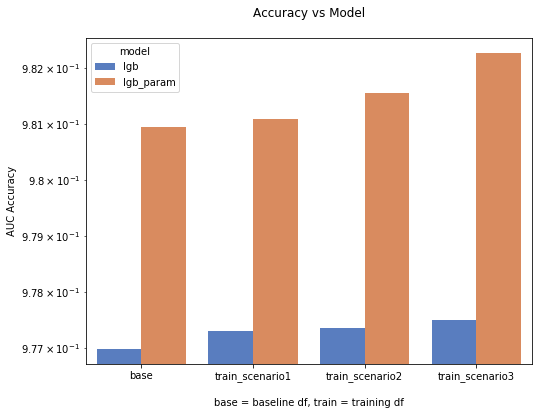

In [546]:
# ploting results

plt.figure(figsize=(8,6))    
plt.title("Accuracy vs Model\n ")

ax = sns.barplot(data=result_metrics, x='dftype', y='test_accuracy', hue='model', palette='muted' ) 
ax.set_ylabel("AUC Accuracy")    
ax.set_xlabel("\nbase = baseline df, train = training df")
ax.set_yscale("log")

plt.show()    
    

## Main Findings: 

The ML model created need to solve a highly unbalance binary classify data with a supervised type of learning, therefore LightGBMClassifier ML algorithm was selected for the testing data as proven to have the highest AUC score during the benchmark analysis. Due to the nature of the data and many unidentified features 80% of the analysis was expend in data processing and 20% on modeling process.
AUC for testing and validation are good and on average around 0.98 for training and 0.95 for validation, while accuracy is in the 0.98 range (a max of 0.981446 was obtain during discovery phase)    
See table below some sample of the results during discovery:

### Drawbacks: 
- Even if during test the model shown an accuracy of higher than 0.97, the F1 scores for value 1 are below 0.7, meaning the model is good on predicting ‘0’ values, but poor predicting ‘1’, fraud.
- The run time of LightGBMClassifier with parameters is significant higher, this suggest that we may consider using the model with default parameters if performance is a concern.
    - …see sample of the output of classification report and confusion matrix for each run:


### Other Findings:
- Additional opportunities of improving the model were identified but not executed due to time constrains:
    - Date can be broken into transaction per second to see if the model can identify fraud of consecutive transactions. Instead of just the lag time.
    - During feature importance ranking additional features can be removed to improve process time. Only features with rank of value 0 were eliminated.
    - Other algorithms can be tested to ensure lightGBM still the right choice.
    - Card Id iformation can be combined with dist1 and dist2 to have further unique values and better timelag
- Impediments: the computer used to run these models was a 4-cores cpu and 8 GB of RAM Windows machine. It is recommended to run these processes again with a machine of 64 GB of RAM and 8 core cpu as minimum capacity.
